In [2]:
import os
import re
from datetime import datetime

import pdfplumber
import pandas as pd

# 🔹 YOUR ACTUAL FOLDER PATH
FOLDER = r"C:\Users\rjesh\vre_reports"


def extract_text_from_pdf(path):
    """Concatenate text from all pages of a PDF."""
    with pdfplumber.open(path) as pdf:
        texts = [page.extract_text() or "" for page in pdf.pages]
    return "\n".join(texts)


def parse_report_date(fname, text):
    """Extract date from filename or header 'Report for:' line."""
    # 1) From filename -> 01.01.2025.pdf
    m_file = re.search(r'(\d{2}\.\d{2}\.\d{4})', fname)
    if m_file:
        try:
            return datetime.strptime(m_file.group(1), "%d.%m.%Y").date()
        except ValueError:
            pass

    # 2) From inside PDF text: 'Report for : 1-Jan-25'
    m_text = re.search(r"Report\s+for\s*:\s*([0-9]{1,2}-[A-Za-z]{3}-[0-9]{2,4})", text)
    if m_text:
        date_str = m_text.group(1)
        for fmt in ("%d-%b-%y", "%d-%b-%Y"):
            try:
                return datetime.strptime(date_str, fmt).date()
            except ValueError:
                continue

    return None


def extract_solar_row(text):
    """
    Example: 'Solar hrs (0700-1700hrs) 214654 10:11 6250 40290 46540'
    """
    m = re.search(
        r"Solar\s+hrs.*?(\d+)\s+(\d{1,2}:\d{2})\s+(\d+)\s+(\d+)\s+(\d+)",
        text
    )
    if not m:
        return [None] * 5
    demand, t, wind, solar, vre = m.groups()
    return [int(demand), t, int(wind), int(solar), int(vre)]


def extract_nonsolar_row(text):
    """Example: 'Non Solar hrs 190660 18:29 5912 1189 7101'"""
    m = re.search(
        r"Non\s+Solar\s+hrs.*?(\d+)\s+(\d{1,2}:\d{2})\s+(\d+)\s+(\d+)\s+(\d+)",
        text
    )
    if not m:
        return [None] * 5
    demand, t, wind, solar, vre = m.groups()
    return [int(demand), t, int(wind), int(solar), int(vre)]


def extract_max_gen_and_penetration(text):
    """
    Extract line: wind_MW, wind_time, solar_MW, solar_time,
    vre_MW, vre_time, wind_pct, wind_pct_time, solar_pct,
    solar_pct_time, vre_pct, vre_pct_time
    """
    m = re.search(
        r"(\d+)\s+(\d{1,2}:\d{2})\s+(\d+)\s+(\d{1,2}:\d{2})\s+(\d+)\s+(\d{1,2}:\d{2})"
        r"\s+([\d\.]+)%\s+(\d{1,2}:\d{2})\s+([\d\.]+)%\s+(\d{1,2}:\d{2})\s+([\d\.]+)%\s+(\d{1,2}:\d{2})",
        text
    )
    if not m:
        return [None] * 12

    (wind_mw, wind_t,
     solar_mw, solar_t,
     vre_mw, vre_t,
     wind_pct, wind_pct_t,
     solar_pct, solar_pct_t,
     vre_pct, vre_pct_t) = m.groups()

    return [
        int(wind_mw), wind_t,
        int(solar_mw), solar_t,
        int(vre_mw), vre_t,
        float(wind_pct), wind_pct_t,
        float(solar_pct), solar_pct_t,
        float(vre_pct), vre_pct_t
    ]


def extract_mu_cuf_block(text):
    """
    Capture MU and CUF from the 'REMC Monitored Profile' table.
    We parse last 4 numbers from each line (schedule, actual, deviation, CUF).
    """

    wind_line = re.search(r"(पवन\s*/\s*Wind[^\n]+)", text)
    solar_line = re.search(r"(सौर\s*/\s*Solar[^\n]+)", text)
    total_line = re.search(r"Total\s*\(Wind\+\s*Solar\)[^\n]+", text)

    def get_last4(line):
        if not line:
            return [None] * 4
        nums = re.findall(r"[-+]?\d+\.\d+|[-+]?\d+", line)
        if len(nums) >= 4:
            return [float(x) for x in nums[-4:]]
        return [None] * 4

    wind_vals = get_last4(wind_line.group(1) if wind_line else None)
    solar_vals = get_last4(solar_line.group(1) if solar_line else None)
    total_vals = get_last4(total_line.group(0) if total_line else None)

    return wind_vals, solar_vals, total_vals


def extract_curtailment(text):
    """Extract VRE Curtailment (MU / MW) if present."""
    m_mu = re.search(r"VRE\s+Curtailment\(MU\)\s*([\d\.]+)", text)
    m_mw = re.search(r"Max\s+VRE\s+Curtailment\s*\(MW\)\s*([\d\.]+)", text)

    curt_mu = float(m_mu.group(1)) if m_mu else None
    curt_mw = float(m_mw.group(1)) if m_mw else None

    return curt_mu, curt_mw


# ----------------------------
# 🔥 MAIN LOOP
# ----------------------------
rows = []

for fname in os.listdir(FOLDER):
    if not fname.lower().endswith(".pdf"):
        continue

    path = os.path.join(FOLDER, fname)
    print(f"Processing: {fname}")

    text = extract_text_from_pdf(path)
    report_date = parse_report_date(fname, text)

    # A. Solar / Non-solar hours
    (d_solar, t_solar, w_solar, s_solar, v_solar) = extract_solar_row(text)
    (d_ns, t_ns, w_ns, s_ns, v_ns) = extract_nonsolar_row(text)

    # B. Max gen + penetration
    (max_wind_mw, max_wind_t,
     max_solar_mw, max_solar_t,
     max_vre_mw, max_vre_t,
     wind_pen, wind_pen_t,
     solar_pen, solar_pen_t,
     vre_pen, vre_pen_t) = extract_max_gen_and_penetration(text)

    # C. MU + CUF data
    (wind_vals, solar_vals, total_vals) = extract_mu_cuf_block(text)
    (wind_sched_mu, wind_act_mu, wind_dev_mu, wind_cuf) = wind_vals
    (solar_sched_mu, solar_act_mu, solar_dev_mu, solar_cuf) = solar_vals
    (vre_sched_mu, vre_act_mu, vre_dev_mu, vre_cuf) = total_vals

    # D. Curtailment
    (curt_mu, curt_mw) = extract_curtailment(text)

    rows.append({
        "file_name": fname,
        "report_date": report_date,

        # Solar & non-solar hour demand
        "demand_solar_hrs_mw": d_solar,
        "demand_solar_hrs_time": t_solar,
        "wind_contrib_solar_mw": w_solar,
        "solar_contrib_solar_mw": s_solar,
        "vre_contrib_solar_mw": v_solar,

        "demand_nonsolar_hrs_mw": d_ns,
        "demand_nonsolar_hrs_time": t_ns,
        "wind_contrib_nonsolar_mw": w_ns,
        "solar_contrib_nonsolar_mw": s_ns,
        "vre_contrib_nonsolar_mw": v_ns,

        # Max generation & penetration
        "max_wind_mw": max_wind_mw,
        "max_wind_time": max_wind_t,
        "max_solar_mw": max_solar_mw,
        "max_solar_time": max_solar_t,
        "max_vre_mw": max_vre_mw,
        "max_vre_time": max_vre_t,

        "max_wind_penetration_pct": wind_pen,
        "max_wind_penetration_time": wind_pen_t,
        "max_solar_penetration_pct": solar_pen,
        "max_solar_penetration_time": solar_pen_t,
        "max_vre_penetration_pct": vre_pen,
        "max_vre_penetration_time": vre_pen_t,

        # MU + CUF
        "wind_schedule_mu": wind_sched_mu,
        "wind_actual_mu": wind_act_mu,
        "wind_deviation_mu": wind_dev_mu,
        "wind_cuf_pct": wind_cuf,

        "solar_schedule_mu": solar_sched_mu,
        "solar_actual_mu": solar_act_mu,
        "solar_deviation_mu": solar_dev_mu,
        "solar_cuf_pct": solar_cuf,

        "vre_schedule_mu": vre_sched_mu,
        "vre_actual_mu": vre_act_mu,
        "vre_deviation_mu": vre_dev_mu,
        "vre_cuf_pct": vre_cuf,

        # Curtailment
        "vre_curtailment_mu": curt_mu,
        "vre_curtailment_mw": curt_mw,
    })

# Build DataFrame
df = pd.DataFrame(rows)
df.sort_values("report_date", inplace=True)

# Save output CSV in same folder
OUT_PATH = os.path.join(FOLDER, "VRE_Daily_Summary_25.csv")
df.to_csv(OUT_PATH, index=False, encoding="utf-8-sig")

print("============================================")
print("Extraction Complete!")
print("Saved file:", OUT_PATH)
print("Total days extracted:", len(df))
print("============================================")


Processing: 01.01.2025.pdf
Processing: 01.02.2025.pdf
Processing: 01.03.2025.pdf
Processing: 01.04.2025.pdf
Processing: 01.05.2025.pdf
Processing: 01.06.2025.pdf
Processing: 01.07.2025.pdf
Processing: 01.08.2025_NLDC_REMC_REPORT_128.pdf
Processing: 01.09.2025-NLDC-REMC-REPORT_770.pdf
Processing: 02.01.2025.pdf
Processing: 02.02.2025.pdf
Processing: 02.03.2025.pdf
Processing: 02.04.2025.pdf
Processing: 02.05.2025.pdf
Processing: 02.06.2025.pdf
Processing: 02.07.2025.pdf
Processing: 02.08.2025_NLDC_REMC_REPORT_265.pdf
Processing: 02.09.2025_NLDC_REMC_REPORT_490.pdf
Processing: 03.01.2025.pdf
Processing: 03.02.2025.pdf
Processing: 03.05.2025.pdf
Processing: 03.06.2025.pdf
Processing: 03.07.2025.pdf
Processing: 03.08.2025_NLDC_REMC_REPORT_399.pdf
Processing: 03.09.2025_NLDC_REMC_REPORT_340.pdf
Processing: 04.01.2025.pdf
Processing: 04.02.2025.pdf
Processing: 04.06.2025.pdf
Processing: 04.07.2025.pdf
Processing: 04.08.2025_NLDC_REMC_REPORT_268.pdf
Processing: 04.09.2025_NLDC_REMC_REPORT_110

In [1]:
import os
import pandas as pd

# 🔹 Folder and file paths
FOLDER = r"C:\Users\rjesh\vre_reports"
IN_FILE = os.path.join(FOLDER, "VRE_Daily_Summary_25.csv")
OUT_FILE = os.path.join(FOLDER, "VRE_Daily_Summary_25_cleaned.csv")

# 1️⃣ Load the extracted CSV
df = pd.read_csv(IN_FILE)

# 2️⃣ Ensure report_date is a proper datetime column (if present)
if "report_date" in df.columns:
    df["report_date"] = pd.to_datetime(df["report_date"], errors="coerce")
    # Sort by date so interpolation respects time order
    df = df.sort_values("report_date")

# 3️⃣ Drop completely empty columns (all NaN)
empty_cols = df.columns[df.isna().all()]
print("Dropping completely empty columns:", list(empty_cols))
df = df.drop(columns=empty_cols)

# 4️⃣ Drop obviously unnecessary metadata columns (like file_name)
for col in ["file_name"]:
    if col in df.columns:
        print(f"Dropping metadata column: {col}")
        df = df.drop(columns=[col])

# 5️⃣ Interpolate missing numeric values column-wise
numeric_cols = df.select_dtypes(include=["number"]).columns
print("Numeric columns to interpolate:", list(numeric_cols))

# Interpolate linearly over time, both directions (fills start & end)
df[numeric_cols] = df[numeric_cols].interpolate(
    method="linear",
    limit_direction="both"
)

# 6️⃣ Optionally: if any numeric columns still have NaN (all NaN case),
# you can fill them with 0 or leave as NaN. Here we just report them.
still_nan = df[numeric_cols].columns[df[numeric_cols].isna().any()]
if len(still_nan) > 0:
    print("Warning: some numeric columns still have NaNs (likely very sparse):")
    print(list(still_nan))

# 7️⃣ Save cleaned CSV
df.to_csv(OUT_FILE, index=False, encoding="utf-8-sig")

print("=======================================")
print("Cleaning & interpolation complete.")
print("Input file :", IN_FILE)
print("Output file:", OUT_FILE)
print("Rows:", len(df))
print("Columns after cleaning:", len(df.columns))
print("=======================================")


Dropping completely empty columns: ['demand_solar_hrs_mw', 'demand_solar_hrs_time', 'wind_contrib_solar_mw', 'solar_contrib_solar_mw', 'vre_contrib_solar_mw', 'demand_nonsolar_hrs_mw', 'demand_nonsolar_hrs_time', 'wind_contrib_nonsolar_mw', 'solar_contrib_nonsolar_mw', 'vre_contrib_nonsolar_mw', 'vre_schedule_mu', 'vre_actual_mu', 'vre_deviation_mu', 'vre_cuf_pct', 'vre_curtailment_mu', 'vre_curtailment_mw']
Dropping metadata column: file_name
Numeric columns to interpolate: ['max_wind_mw', 'max_solar_mw', 'max_vre_mw', 'max_wind_penetration_pct', 'max_solar_penetration_pct', 'max_vre_penetration_pct', 'wind_schedule_mu', 'wind_actual_mu', 'wind_deviation_mu', 'wind_cuf_pct', 'solar_schedule_mu', 'solar_actual_mu', 'solar_deviation_mu', 'solar_cuf_pct']
Cleaning & interpolation complete.
Input file : C:\Users\rjesh\vre_reports\VRE_Daily_Summary_25.csv
Output file: C:\Users\rjesh\vre_reports\VRE_Daily_Summary_25_cleaned.csv
Rows: 204
Columns after cleaning: 21


In [2]:
import os
import pandas as pd

# ✅ Your actual file paths
PSP_FILE = r"C:\Users\rjesh\PSP_cleaned_data_v2.csv"
VRE_FILE = r"C:\Users\rjesh\vre_reports\VRE_Daily_Summary_25_cleaned.csv"

# Where to save the merged master file
OUT_FILE = r"C:\Users\rjesh\vre_reports\master_pnl_daily.csv"

# 1️⃣ Load PSP cleaned data (all-India)
psp = pd.read_csv(PSP_FILE)

# Try to standardize the date column name
date_col_candidates = ["Data_Date", "Date", "DATE"]
psp_date_col = None
for c in date_col_candidates:
    if c in psp.columns:
        psp_date_col = c
        break

if psp_date_col is None:
    raise ValueError("Could not find a suitable date column in PSP file.")

psp["Date"] = pd.to_datetime(psp[psp_date_col], errors="coerce")

# Keep only the main PSP rows (drop *_freq rows if Source_File exists)
if "Source_File" in psp.columns:
    psp_daily = psp[psp["Source_File"].str.contains("NLDC_PSP", na=False)].copy()
else:
    psp_daily = psp.copy()

# 2️⃣ Ensure RE columns exist; if missing, create as 0
for col in ["Total_Solar", "Total_Wind", "Total_Hydro"]:
    if col not in psp_daily.columns:
        print(f"Column '{col}' not found in PSP. Filling as 0.0")
        psp_daily[col] = 0.0

# 3️⃣ Compute daily total VRE (MU) and PNL from PSP
# Assumption: Total_Energy is daily MU for all generation
if "Total_Energy" not in psp_daily.columns:
    raise ValueError("PSP file must contain 'Total_Energy' column (daily MU).")

# VRE MU from PSP
psp_daily["Total_VRE_MU"] = (
    psp_daily["Total_Solar"].fillna(0)
    + psp_daily["Total_Wind"].fillna(0)
    + psp_daily["Total_Hydro"].fillna(0)
)

# Energy-based net load (MU)
psp_daily["PNL_Energy_MU"] = psp_daily["Total_Energy"] - psp_daily["Total_VRE_MU"]

# Peak net load (MW) if Total_Demand is daily peak MW
if "Total_Demand" in psp_daily.columns:
    psp_daily["PNL_peak_PSP_MW"] = psp_daily["Total_Demand"] - (
        psp_daily["Total_Solar"].fillna(0)
        + psp_daily["Total_Wind"].fillna(0)
        + psp_daily["Total_Hydro"].fillna(0)
    )
else:
    print("Warning: 'Total_Demand' not found in PSP; PNL_peak_PSP_MW will be NaN.")
    psp_daily["PNL_peak_PSP_MW"] = pd.NA

# Keep only relevant PSP columns for merge
psp_keep_cols = [
    "Date",
    "Total_Demand",
    "Total_Energy",
    "Total_Solar",
    "Total_Wind",
    "Total_Hydro",
    "Total_VRE_MU",
    "PNL_Energy_MU",
    "PNL_peak_PSP_MW",
]
psp_keep = psp_daily[[c for c in psp_keep_cols if c in psp_daily.columns]].copy()

# 4️⃣ Load VRE daily summary (from REMC PDFs)
vre = pd.read_csv(VRE_FILE)

if "report_date" not in vre.columns:
    raise ValueError("VRE file must contain 'report_date' column.")

vre["report_date"] = pd.to_datetime(vre["report_date"], errors="coerce")

# 5️⃣ Compute PNL (net load) at solar and non-solar peaks from VRE file
# PNL at solar hours peak
if {"demand_solar_hrs_mw", "vre_contrib_solar_mw"}.issubset(vre.columns):
    vre["PNL_solar_peak_MW"] = (
        vre["demand_solar_hrs_mw"] - vre["vre_contrib_solar_mw"]
    )
else:
    print("Columns for solar peak PNL not fully present in VRE file.")
    vre["PNL_solar_peak_MW"] = pd.NA

# PNL at non-solar hours peak
if {"demand_nonsolar_hrs_mw", "vre_contrib_nonsolar_mw"}.issubset(vre.columns):
    vre["PNL_nonsolar_peak_MW"] = (
        vre["demand_nonsolar_hrs_mw"] - vre["vre_contrib_nonsolar_mw"]
    )
else:
    print("Columns for non-solar peak PNL not fully present in VRE file.")
    vre["PNL_nonsolar_peak_MW"] = pd.NA

# 6️⃣ Merge PSP + VRE on date
master = pd.merge(
    psp_keep,
    vre,
    left_on="Date",
    right_on="report_date",
    how="outer",
    suffixes=("_psp", "_vre")
)

# Sort by date for sanity
master = master.sort_values("Date")

# 7️⃣ Save final master daily PNL dataset
master.to_csv(OUT_FILE, index=False, encoding="utf-8-sig")

print("==============================================")
print("Master PNL daily dataset created successfully.")
print("Output file:", OUT_FILE)
print("Total rows:", len(master))
print("Total columns:", len(master.columns))
print("==============================================")


Columns for solar peak PNL not fully present in VRE file.
Columns for non-solar peak PNL not fully present in VRE file.
Master PNL daily dataset created successfully.
Output file: C:\Users\rjesh\vre_reports\master_pnl_daily.csv
Total rows: 440
Total columns: 32


C:\Users\rjesh\AppData\Local\Temp\ipykernel_23256\65349590.py:25: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  psp["Date"] = pd.to_datetime(psp[psp_date_col], errors="coerce")


In [3]:
import pandas as pd
import os

# Paths
INPUT_FILE = r"C:\Users\rjesh\vre_reports\master_pnl_daily.csv"
OUTPUT_FILE = r"C:\Users\rjesh\vre_reports\master_pnl_daily_filled.csv"

# 1) Load dataset
df = pd.read_csv(INPUT_FILE)

# 2) Fix date column
date_col_candidates = ["Date", "report_date", "date"]
df_date_col = None
for col in date_col_candidates:
    if col in df.columns:
        df_date_col = col
        break

if df_date_col is None:
    raise ValueError("No valid date column found in master_pnl_daily.csv")

df[df_date_col] = pd.to_datetime(df[df_date_col], errors="coerce")
df = df.sort_values(df_date_col)

# 3) Identify numeric columns
numeric_cols = df.select_dtypes(include=["number"]).columns

print("Numeric columns to interpolate:")
print(list(numeric_cols))

# 4) Interpolate missing values
df[numeric_cols] = df[numeric_cols].interpolate(
    method="linear",
    limit_direction="both"
)

# 5) Optional: if some numeric columns are still entirely NaN (rare), fill with 0
still_nan_cols = df[numeric_cols].columns[df[numeric_cols].isna().any()]
if len(still_nan_cols) > 0:
    print("Still missing, filling with 0:", list(still_nan_cols))
    df[still_nan_cols] = df[still_nan_cols].fillna(0)

# 6) Save cleaned file
df.to_csv(OUTPUT_FILE, index=False, encoding="utf-8-sig")

print("===================================================")
print("Missing values handled using interpolation.")
print("Clean file saved as:", OUTPUT_FILE)
print("Total rows:", len(df))
print("Total columns:", len(df.columns))
print("===================================================")


Numeric columns to interpolate:
['Total_Demand', 'Total_Energy', 'Total_Solar', 'Total_Wind', 'Total_Hydro', 'Total_VRE_MU', 'PNL_Energy_MU', 'PNL_peak_PSP_MW', 'max_wind_mw', 'max_solar_mw', 'max_vre_mw', 'max_wind_penetration_pct', 'max_solar_penetration_pct', 'max_vre_penetration_pct', 'wind_schedule_mu', 'wind_actual_mu', 'wind_deviation_mu', 'wind_cuf_pct', 'solar_schedule_mu', 'solar_actual_mu', 'solar_deviation_mu', 'solar_cuf_pct', 'PNL_solar_peak_MW', 'PNL_nonsolar_peak_MW']
Still missing, filling with 0: ['PNL_solar_peak_MW', 'PNL_nonsolar_peak_MW']
Missing values handled using interpolation.
Clean file saved as: C:\Users\rjesh\vre_reports\master_pnl_daily_filled.csv
Total rows: 440
Total columns: 32


In [4]:
import pandas as pd
import os

INPUT_FILE = r"C:\Users\rjesh\vre_reports\master_pnl_daily.csv"
OUTPUT_FILE = r"C:\Users\rjesh\vre_reports\master_pnl_daily_fixed.csv"

# 1) Load dataset
df = pd.read_csv(INPUT_FILE)

# 2) Identify the date column
date_cols = ["Date", "report_date", "date"]
date_col = None
for c in date_cols:
    if c in df.columns:
        date_col = c
        break

if date_col is None:
    raise ValueError("No valid date column (Date/report_date) found in the file.")

# 3) Convert to datetime (coerce = convert invalid to NaT)
df[date_col] = pd.to_datetime(df[date_col], errors="coerce")

# 4) Drop rows where date is missing
before = len(df)
df = df.dropna(subset=[date_col])
after = len(df)

print(f"Removed {before - after} rows with missing or invalid dates.")

# 5) Sort by date
df = df.sort_values(date_col)

# 6) Optional: reset the index
df = df.reset_index(drop=True)

# 7) Save the cleaned file
df.to_csv(OUTPUT_FILE, index=False, encoding="utf-8-sig")

print("=============================================")
print("Date-cleaning complete.")
print("Clean file saved as:", OUTPUT_FILE)
print("Remaining rows:", len(df))
print("=============================================")


Removed 68 rows with missing or invalid dates.
Date-cleaning complete.
Clean file saved as: C:\Users\rjesh\vre_reports\master_pnl_daily_fixed.csv
Remaining rows: 372


In [5]:
import pandas as pd
import os

# Input and output paths
INPUT_FILE = r"C:\Users\rjesh\vre_reports\master_pnl_daily_fixed.csv"
OUTPUT_FILE = r"C:\Users\rjesh\vre_reports\master_pnl_daily_clean_final.csv"

# 1) Load cleaned dataset
df = pd.read_csv(INPUT_FILE)

# 2) Identify date column again
date_cols = ["Date", "report_date", "date"]
date_col = None
for col in date_cols:
    if col in df.columns:
        date_col = col
        break

if date_col is None:
    raise ValueError("No valid date column found.")

# Convert to datetime
df[date_col] = pd.to_datetime(df[date_col], errors="coerce")

# Sort by date
df = df.sort_values(date_col)

# 3) Interpolate numeric columns
numeric_cols = df.select_dtypes(include=["number"]).columns

print("Interpolating numeric columns:")
print(list(numeric_cols))

# Linear interpolation (both directions)
df[numeric_cols] = df[numeric_cols].interpolate(
    method="linear",
    limit_direction="both"
)

# 4) Forward fill and backward fill for ANY remaining missing values
df = df.fillna(method='ffill').fillna(method='bfill')

# 5) Drop any leftover rows where dates or values are still missing
missing_before = df.isna().sum().sum()
print("Missing values BEFORE removing rows:", missing_before)

df = df.dropna()

missing_after = df.isna().sum().sum()

print("Missing values AFTER cleaning:", missing_after)

# 6) Save final fully cleaned dataset
df.to_csv(OUTPUT_FILE, index=False, encoding="utf-8-sig")

print("============================================")
print("All missing values handled successfully.")
print("Clean dataset saved as:", OUTPUT_FILE)
print("Total rows:", len(df))
print("Total columns:", len(df.columns))
print("============================================")


Interpolating numeric columns:
['Total_Demand', 'Total_Energy', 'Total_Solar', 'Total_Wind', 'Total_Hydro', 'Total_VRE_MU', 'PNL_Energy_MU', 'PNL_peak_PSP_MW', 'max_wind_mw', 'max_solar_mw', 'max_vre_mw', 'max_wind_penetration_pct', 'max_solar_penetration_pct', 'max_vre_penetration_pct', 'wind_schedule_mu', 'wind_actual_mu', 'wind_deviation_mu', 'wind_cuf_pct', 'solar_schedule_mu', 'solar_actual_mu', 'solar_deviation_mu', 'solar_cuf_pct', 'PNL_solar_peak_MW', 'PNL_nonsolar_peak_MW']
Missing values BEFORE removing rows: 744
Missing values AFTER cleaning: 0.0
All missing values handled successfully.
Clean dataset saved as: C:\Users\rjesh\vre_reports\master_pnl_daily_clean_final.csv
Total rows: 0
Total columns: 32


In [6]:
import pandas as pd

file = r"C:\Users\rjesh\vre_reports\master_pnl_daily_fixed_new.csv"
df = pd.read_csv(file)

print("=== Missing Value Summary ===")
print(df.isna().sum())

print("\n=== Total Missing Values ===")
print(df.isna().sum().sum())

if df.isna().sum().sum() == 0:
    print("\n✔ GOOD NEWS: No missing values found. File is clean.")
else:
    print("\n⚠ Missing values detected. We need to fix them.")


=== Missing Value Summary ===
Date                           42
Total_Demand                   42
Total_Energy                   42
Total_Solar                    42
Total_Wind                     42
Total_Hydro                    42
Total_VRE_MU                   42
PNL_Energy_MU                  42
PNL_peak_PSP_MW                42
report_date                    42
max_wind_mw                    42
max_wind_time                  42
max_solar_mw                   42
max_solar_time                 42
max_vre_mw                     42
max_vre_time                   42
max_wind_penetration_pct       42
max_wind_penetration_time      42
max_solar_penetration_pct      42
max_solar_penetration_time     42
max_vre_penetration_pct        42
max_vre_penetration_time       42
wind_schedule_mu               42
wind_actual_mu                 42
wind_deviation_mu              42
wind_cuf_pct                   42
solar_schedule_mu              42
solar_actual_mu                42
solar_deviation_mu

In [7]:
import pandas as pd

file = r"C:\Users\rjesh\vre_reports\master_pnl_daily_fixed_new.csv"
df = pd.read_csv(file)

print("=== Missing Value Summary ===")
print(df.isna().sum())

print("\n=== Total Missing Values ===")
print(df.isna().sum().sum())

if df.isna().sum().sum() == 0:
    print("\n✔ GOOD NEWS: No missing values found. File is clean.")
else:
    print("\n⚠ Missing values detected. We need to fix them.")


=== Missing Value Summary ===
Date                          42
Total_Demand                  42
Total_Energy                  42
Total_Solar                   42
Total_Wind                    42
Total_Hydro                   42
Total_VRE_MU                  42
PNL_Energy_MU                 42
PNL_peak_PSP_MW               42
report_date                   42
max_wind_mw                   42
max_wind_time                 42
max_solar_mw                  42
max_solar_time                42
max_vre_mw                    42
max_vre_time                  42
max_wind_penetration_pct      42
max_wind_penetration_time     42
max_solar_penetration_pct     42
max_solar_penetration_time    42
max_vre_penetration_pct       42
max_vre_penetration_time      42
wind_schedule_mu              42
wind_actual_mu                42
wind_deviation_mu             42
wind_cuf_pct                  42
solar_schedule_mu             42
solar_actual_mu               42
solar_deviation_mu            42
solar_cuf_pct

In [8]:
import pandas as pd

# 👉 Your files
PNL_FILE   = r"C:\Users\rjesh\vre_reports\master_pnl_daily_fixed_new.csv"
NASA_FILE  = r"C:\Users\rjesh\Nasa_all_25.csv"
OUTPUT_FILE = r"C:\Users\rjesh\vre_reports\final_master_dataset.csv"

# ==============================
# 1️⃣ LOAD NASA WEATHER DATA
# ==============================

weather = pd.read_csv(NASA_FILE)

# YEAR, MO, DY  →  Date
weather["Date"] = pd.to_datetime(
    weather["YEAR"].astype(str) + "-" +
    weather["MO"].astype(str)   + "-" +
    weather["DY"].astype(str),
    errors="coerce"
)

# If you have already removed the bad column(s),
# we DON'T need any -999 replacement here.

# Drop YEAR, MO, DY (we now have Date)
weather = weather.drop(columns=["YEAR", "MO", "DY"], errors="ignore")

# Interpolate numeric weather columns (just in case)
num_cols_weather = weather.select_dtypes(include=["number"]).columns
weather[num_cols_weather] = weather[num_cols_weather].interpolate(
    method="linear",
    limit_direction="both"
)

# ==============================
# 2️⃣ LOAD PNL DATA
# ==============================

pnl = pd.read_csv(PNL_FILE)

# Find date column
date_cols = ["Date", "DATE", "report_date"]
pnl_date_col = None
for c in date_cols:
    if c in pnl.columns:
        pnl_date_col = c
        break

if pnl_date_col is None:
    raise ValueError("No valid date column found in PNL dataset.")

# Standardize to 'Date'
pnl["Date"] = pd.to_datetime(pnl[pnl_date_col], errors="coerce")
pnl = pnl.dropna(subset=["Date"])
pnl = pnl.sort_values("Date")

# Interpolate numeric PNL columns (if any tiny gaps)
num_cols_pnl = pnl.select_dtypes(include=["number"]).columns
pnl[num_cols_pnl] = pnl[num_cols_pnl].interpolate(
    method="linear",
    limit_direction="both"
)

# ==============================
# 3️⃣ MERGE WEATHER + PNL
# ==============================

master = pd.merge(
    pnl,
    weather,
    on="Date",
    how="inner"     # keep only dates present in both
)

master = master.sort_values("Date")

# Save final merged dataset
master.to_csv(OUTPUT_FILE, index=False, encoding="utf-8-sig")

print("======================================")
print("MERGE COMPLETE!")
print("Merged dataset saved as:", OUTPUT_FILE)
print("Total rows :", len(master))
print("Total cols :", len(master.columns))
print("======================================")


MERGE COMPLETE!
Merged dataset saved as: C:\Users\rjesh\vre_reports\final_master_dataset.csv
Total rows : 136
Total cols : 36


C:\Users\rjesh\AppData\Local\Temp\ipykernel_23256\4202751290.py:53: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  pnl["Date"] = pd.to_datetime(pnl[pnl_date_col], errors="coerce")


Dataset shape: (136, 36)

Columns:
 Index(['Date', 'Total_Demand', 'Total_Energy', 'Total_Solar', 'Total_Wind',
       'Total_Hydro', 'Total_VRE_MU', 'PNL_Energy_MU', 'PNL_peak_PSP_MW',
       'report_date', 'max_wind_mw', 'max_wind_time', 'max_solar_mw',
       'max_solar_time', 'max_vre_mw', 'max_vre_time',
       'max_wind_penetration_pct', 'max_wind_penetration_time',
       'max_solar_penetration_pct', 'max_solar_penetration_time',
       'max_vre_penetration_pct', 'max_vre_penetration_time',
       'wind_schedule_mu', 'wind_actual_mu', 'wind_deviation_mu',
       'wind_cuf_pct', 'solar_schedule_mu', 'solar_actual_mu',
       'solar_deviation_mu', 'solar_cuf_pct', 'ALLSKY_SFC_SW_DWN', 'T2M',
       'WS10M', 'WS50M', 'RH2M', 'ALLSKY_KT'],
      dtype='object')

Missing values:
 Date                          0
Total_Demand                  0
Total_Energy                  0
Total_Solar                   0
Total_Wind                    0
Total_Hydro                   0
Total_VRE_MU   

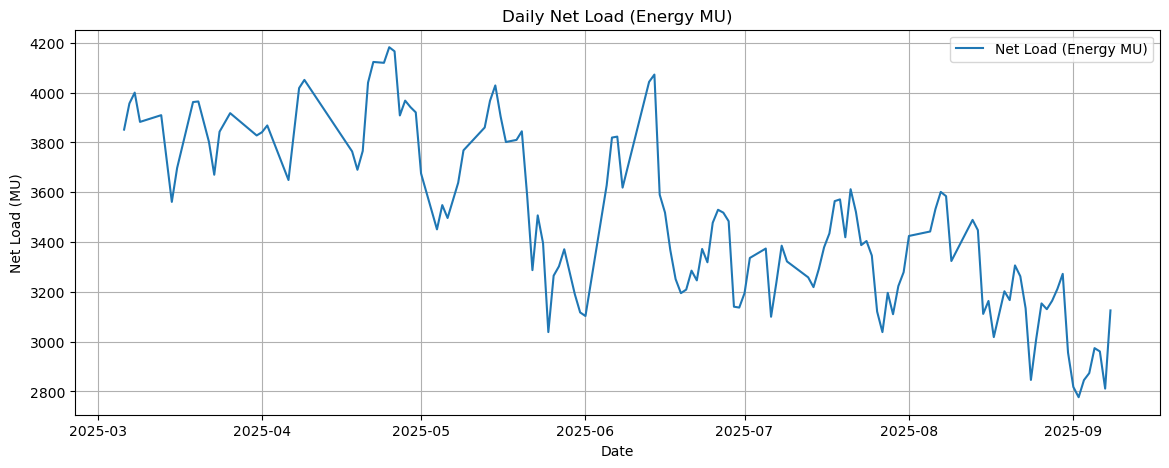

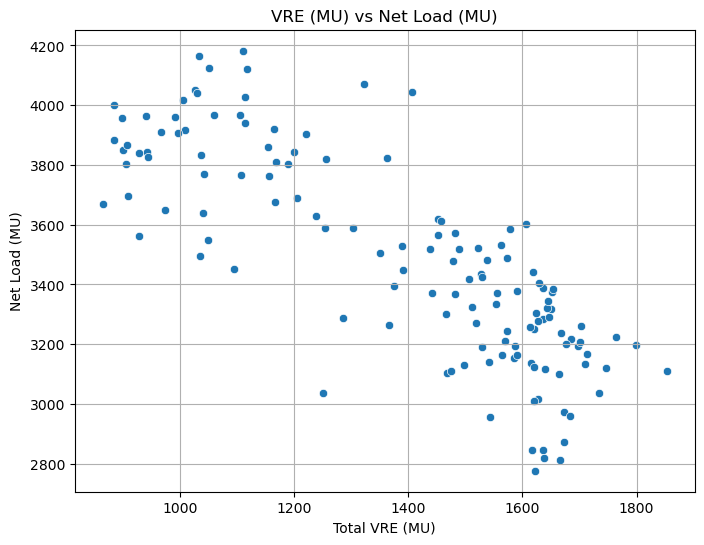

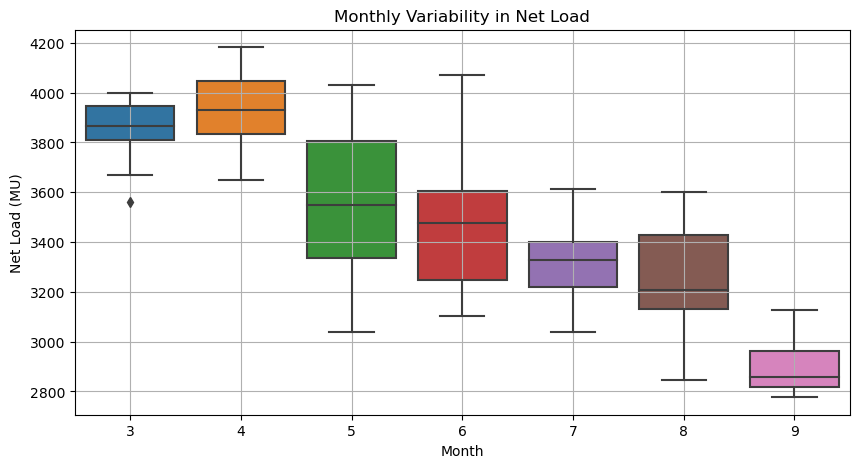

C:\Users\rjesh\AppData\Local\Temp\ipykernel_23256\2578438796.py:94: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), cmap="coolwarm", annot=False)


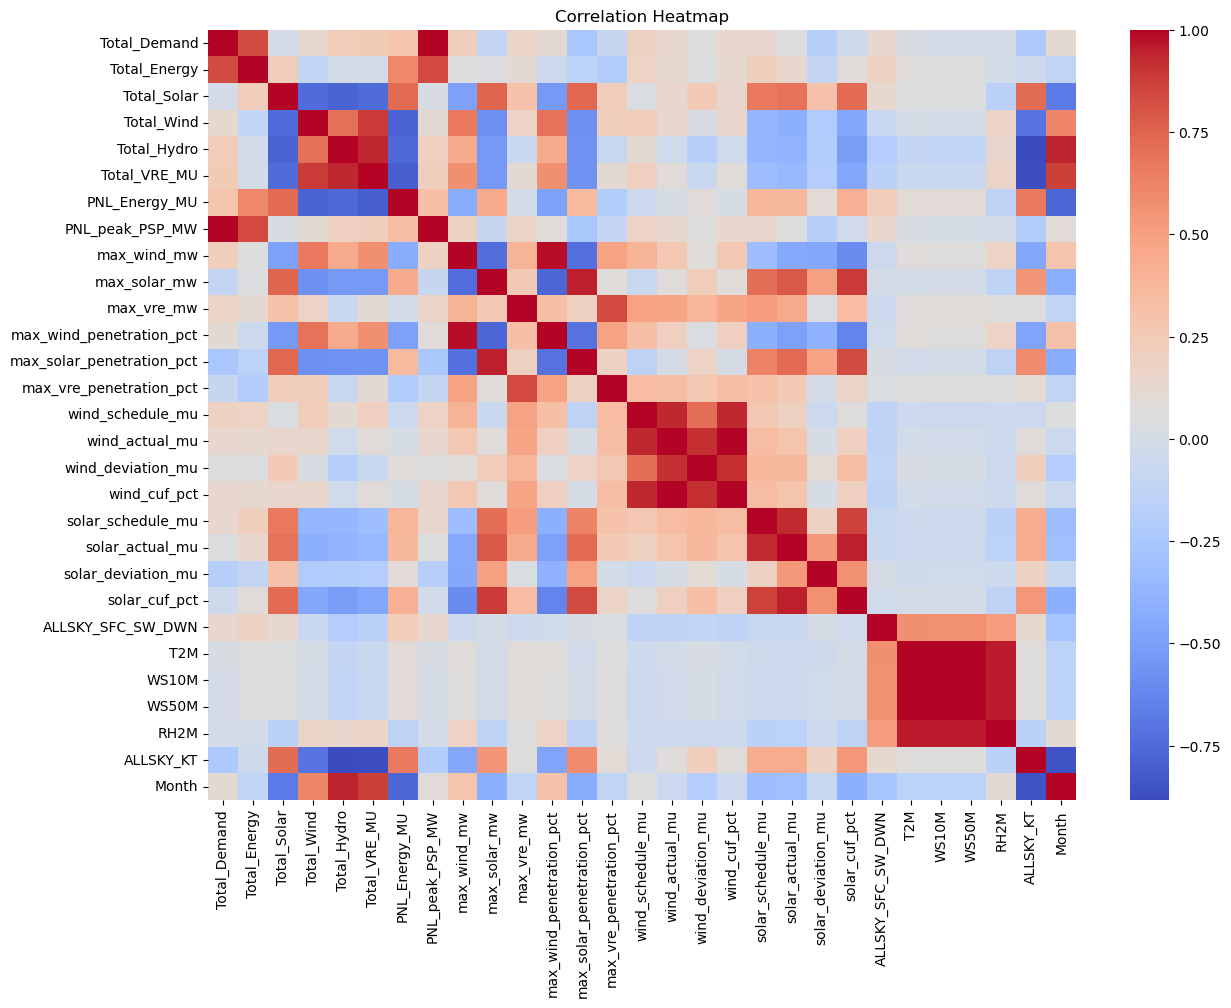

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
file = r"C:\Users\rjesh\vre_reports\final_master_dataset.csv"
df = pd.read_csv(file)

# Ensure date is proper datetime
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# ================================
# 1️⃣ BASIC SUMMARY
# ================================
print("Dataset shape:", df.shape)
print("\nColumns:\n", df.columns)
print("\nMissing values:\n", df.isna().sum())

print("\nSummary statistics:")
print(df.describe().T)

# ================================
# 2️⃣ NET LOAD TREND (MAIN PLOT)
# ================================
plt.figure(figsize=(14,5))
plt.plot(df['Date'], df['PNL_Energy_MU'], label="Net Load (Energy MU)")
plt.title("Daily Net Load (Energy MU)")
plt.xlabel("Date")
plt.ylabel("Net Load (MU)")
plt.grid(True)
plt.legend()
plt.show()

# ================================
# 3️⃣ DEMAND & VRE TRENDS
# ================================
plt.figure(figsize=(14,5))
plt.plot(df['Date'], df['Total_Demand'], label="Total Demand (MW)")
plt.plot(df['Date'], df['Total_Solar'], label="Solar (MU)")
plt.plot(df['Date'], df['Total_Wind'], label="Wind (MU)")
plt.title("Daily Demand and VRE Generation")
plt.legend()
plt.grid(True)
plt.show()

# ================================
# 4️⃣ SCATTER: VRE vs NET LOAD
# ================================
plt.figure(figsize=(8,6))
sns.scatterplot(x=df['Total_VRE_MU'], y=df['PNL_Energy_MU'])
plt.title("VRE (MU) vs Net Load (MU)")
plt.xlabel("Total VRE (MU)")
plt.ylabel("Net Load (MU)")
plt.grid(True)
plt.show()

# ================================
# 5️⃣ WEATHER RELATIONSHIPS
# ================================
plt.figure(figsize=(8,6))
sns.scatterplot(x=df['ALLSKY_SFC_SW_DWN'], y=df['Total_Solar'])
plt.title("Irradiance vs Solar Generation")
plt.xlabel("Solar Irradiance")
plt.ylabel("Solar Generation (MU)")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(x=df['WS10M'], y=df['Total_Wind'])
plt.title("Wind Speed vs Wind Generation")
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Wind Generation (MU)")
plt.grid(True)
plt.show()

# ================================
# 6️⃣ MONTHLY SEASONALITY
# ================================
df['Month'] = df['Date'].dt.month

plt.figure(figsize=(10,5))
sns.boxplot(x=df['Month'], y=df['PNL_Energy_MU'])
plt.title("Monthly Variability in Net Load")
plt.xlabel("Month")
plt.ylabel("Net Load (MU)")
plt.grid(True)
plt.show()

# ================================
# 7️⃣ CORRELATION HEATMAP
# ================================
plt.figure(figsize=(14,10))
sns.heatmap(df.corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap")
plt.show()


In [1]:
import pandas as pd

file = r"C:\Users\rjesh\vre_reports\final_master_dataset.csv"
df = pd.read_csv(file)

# 1) Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# 2) Drop duplicate "report_date"
if 'report_date' in df.columns:
    df = df.drop(columns=['report_date'])

# 3) Replace NASA missing markers -999 with NaN
df = df.replace(-999, pd.NA).replace(-999.0, pd.NA)

# 4) Drop ALLSKY_KT (mostly missing values)
if df['ALLSKY_KT'].isna().sum() > 0.75 * len(df):
    df = df.drop(columns=['ALLSKY_KT'])

# 5) Interpolate remaining NASA weather values
numeric_cols = df.select_dtypes(include=['number']).columns
df[numeric_cols] = df[numeric_cols].interpolate(
    method='linear',
    limit_direction='both'
)

# 6) Save cleaned version
clean_file = r"C:\Users\rjesh\vre_reports\final_master_dataset_clean.csv"
df.to_csv(clean_file, index=False, encoding="utf-8-sig")

print("CLEANED DATASET SAVED AS:", clean_file)
print("Missing values after cleaning:", df.isna().sum().sum())


KeyError: 'Date'

In [2]:
import pandas as pd

file = r"C:\Users\rjesh\vre_reports\final_master_dataset.csv"
df = pd.read_csv(file)

print(df.columns)


Index(['Date\tTotal_Demand\tTotal_Energy\tTotal_Solar\tTotal_Wind\tTotal_Hydro\tTotal_VRE_MU\tPNL_Energy_MU\tPNL_peak_PSP_MW\treport_date\tmax_wind_mw\tmax_wind_time\tmax_solar_mw\tmax_solar_time\tmax_vre_mw\tmax_vre_time\tmax_wind_penetration_pct\tmax_wind_penetration_time\tmax_solar_penetration_pct\tmax_solar_penetration_time\tmax_vre_penetration_pct\tmax_vre_penetration_time\twind_schedule_mu\twind_actual_mu\twind_deviation_mu\twind_cuf_pct\tsolar_schedule_mu\tsolar_actual_mu\tsolar_deviation_mu\tsolar_cuf_pct\tALLSKY_SFC_SW_DWN\tT2M\tWS10M\tWS50M\tRH2M\tALLSKY_KT'], dtype='object')


In [ ]:
import pandas as pd

file = r"C:\Users\rjesh\vre_reports\final_master_dataset.csv"

# 1. Read as TAB-separated file
df = pd.read_csv(file, sep="\t")

print("Columns detected:")
print(df.columns)

# 2. Identify correct date column
possible_date_cols = ["Date", "DATE", "date", "report_date"]
date_col = None

for col in df.columns:
    if col.strip() in possible_date_cols:
        date_col = col
        break

print("Detected date column:", date_col)

# 3. Convert to datetime
df["Date"] = pd.to_datetime(df[date_col], errors="coerce")

# 4. Drop extra report_date
if "report_date" in df.columns:
    df = df.drop(columns=["report_date"], errors="ignore")

# 5. Replace NASA missing values
df = df.replace([-999, -999.0, -9999], pd.NA)

# 6. Drop ALLSKY_KT (mostly missing)
if "ALLSKY_KT" in df.columns:
    if df["ALLSKY_KT"].isna().mean() > 0.75:
        df = df.drop(columns=["ALLSKY_KT"])

# 7. Interpolate numeric columns
num_cols = df.select_dtypes(include=["number"]).columns
df[num_cols] = df[num_cols].interpolate(method="linear", limit_direction="both")

# 8. Drop rows where Date is invalid
df = df.dropna(subset=["Date"])

# 9. Save clean dataset
out = r"C:\Users\rjesh\vre_reports\final_master_dataset_clean.csv"
df.to_csv(out, index=False, encoding="utf-8-sig")

print("Cleaned dataset saved to:", out)
print("Missing values:", df.isna().sum().sum())


In [1]:
import pandas as pd

file = r"C:\Users\rjesh\vre_reports\final_master_dataset.csv"    # or final_master_dataset_fixed.csv
df = pd.read_csv(file)

print("Columns detected:")
print(df.columns.tolist())


Columns detected:
['Date\tTotal_Demand\tTotal_Energy\tTotal_Solar\tTotal_Wind\tTotal_Hydro\tTotal_VRE_MU\tPNL_Energy_MU\tPNL_peak_PSP_MW\treport_date\tmax_wind_mw\tmax_wind_time\tmax_solar_mw\tmax_solar_time\tmax_vre_mw\tmax_vre_time\tmax_wind_penetration_pct\tmax_wind_penetration_time\tmax_solar_penetration_pct\tmax_solar_penetration_time\tmax_vre_penetration_pct\tmax_vre_penetration_time\twind_schedule_mu\twind_actual_mu\twind_deviation_mu\twind_cuf_pct\tsolar_schedule_mu\tsolar_actual_mu\tsolar_deviation_mu\tsolar_cuf_pct\tALLSKY_SFC_SW_DWN\tT2M\tWS10M\tWS50M\tRH2M\tALLSKY_KT']


In [2]:
import pandas as pd

# 👉 Your files
PNL_FILE   = r"C:\Users\rjesh\vre_reports\master_pnl_daily_fixed_new.csv"
NASA_FILE  = r"C:\Users\rjesh\Nasa_all_25.csv"
OUTPUT_FILE = r"C:\Users\rjesh\vre_reports\final_master_dataset.csv"

# ==============================
# 1️⃣ LOAD NASA WEATHER DATA
# ==============================

weather = pd.read_csv(NASA_FILE)

# YEAR, MO, DY  →  Date
weather["Date"] = pd.to_datetime(
    weather["YEAR"].astype(str) + "-" +
    weather["MO"].astype(str)   + "-" +
    weather["DY"].astype(str),
    errors="coerce"
)

# If you have already removed the bad column(s),
# we DON'T need any -999 replacement here.

# Drop YEAR, MO, DY (we now have Date)
weather = weather.drop(columns=["YEAR", "MO", "DY"], errors="ignore")

# Interpolate numeric weather columns (just in case)
num_cols_weather = weather.select_dtypes(include=["number"]).columns
weather[num_cols_weather] = weather[num_cols_weather].interpolate(
    method="linear",
    limit_direction="both"
)

# ==============================
# 2️⃣ LOAD PNL DATA
# ==============================

pnl = pd.read_csv(PNL_FILE)

# Find date column
date_cols = ["Date", "DATE", "report_date"]
pnl_date_col = None
for c in date_cols:
    if c in pnl.columns:
        pnl_date_col = c
        break

if pnl_date_col is None:
    raise ValueError("No valid date column found in PNL dataset.")

# Standardize to 'Date'
pnl["Date"] = pd.to_datetime(pnl[pnl_date_col], errors="coerce")
pnl = pnl.dropna(subset=["Date"])
pnl = pnl.sort_values("Date")

# Interpolate numeric PNL columns (if any tiny gaps)
num_cols_pnl = pnl.select_dtypes(include=["number"]).columns
pnl[num_cols_pnl] = pnl[num_cols_pnl].interpolate(
    method="linear",
    limit_direction="both"
)

# ==============================
# 3️⃣ MERGE WEATHER + PNL
# ==============================

master = pd.merge(
    pnl,
    weather,
    on="Date",
    how="inner"     # keep only dates present in both
)

master = master.sort_values("Date")

# Save final merged dataset
master.to_csv(OUTPUT_FILE, index=False, encoding="utf-8-sig")

print("======================================")
print("MERGE COMPLETE!")
print("Merged dataset saved as:", OUTPUT_FILE)
print("Total rows :", len(master))
print("Total cols :", len(master.columns))
print("======================================")


MERGE COMPLETE!
Merged dataset saved as: C:\Users\rjesh\vre_reports\final_master_dataset.csv
Total rows : 136
Total cols : 36


C:\Users\rjesh\AppData\Local\Temp\ipykernel_19192\4202751290.py:53: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  pnl["Date"] = pd.to_datetime(pnl[pnl_date_col], errors="coerce")


In [3]:
import pandas as pd

file = r"C:\Users\rjesh\vre_reports\final_master_dataset.csv"    # or final_master_dataset_fixed.csv
df = pd.read_csv(file)

print("Columns detected:")
print(df.columns.tolist())


Columns detected:
['Date', 'Total_Demand', 'Total_Energy', 'Total_Solar', 'Total_Wind', 'Total_Hydro', 'Total_VRE_MU', 'PNL_Energy_MU', 'PNL_peak_PSP_MW', 'report_date', 'max_wind_mw', 'max_wind_time', 'max_solar_mw', 'max_solar_time', 'max_vre_mw', 'max_vre_time', 'max_wind_penetration_pct', 'max_wind_penetration_time', 'max_solar_penetration_pct', 'max_solar_penetration_time', 'max_vre_penetration_pct', 'max_vre_penetration_time', 'wind_schedule_mu', 'wind_actual_mu', 'wind_deviation_mu', 'wind_cuf_pct', 'solar_schedule_mu', 'solar_actual_mu', 'solar_deviation_mu', 'solar_cuf_pct', 'ALLSKY_SFC_SW_DWN', 'T2M', 'WS10M', 'WS50M', 'RH2M', 'ALLSKY_KT']


In [1]:
import pandas as pd

file = r"C:\Users\rjesh\vre_reports\final_master_dataset.csv"

# 1. Read as TAB-separated file
df = pd.read_csv(file, sep="\t")

print("Columns detected:")
print(df.columns)

# 2. Identify correct date column
possible_date_cols = ["Date", "DATE", "date", "report_date"]
date_col = None

for col in df.columns:
    if col.strip() in possible_date_cols:
        date_col = col
        break

print("Detected date column:", date_col)

# 3. Convert to datetime
df["Date"] = pd.to_datetime(df[date_col], errors="coerce")

# 4. Drop extra report_date
if "report_date" in df.columns:
    df = df.drop(columns=["report_date"], errors="ignore")

# 5. Replace NASA missing values
df = df.replace([-999, -999.0, -9999], pd.NA)

# 6. Drop ALLSKY_KT (mostly missing)
if "ALLSKY_KT" in df.columns:
    if df["ALLSKY_KT"].isna().mean() > 0.75:
        df = df.drop(columns=["ALLSKY_KT"])

# 7. Interpolate numeric columns
num_cols = df.select_dtypes(include=["number"]).columns
df[num_cols] = df[num_cols].interpolate(method="linear", limit_direction="both")

# 8. Drop rows where Date is invalid
df = df.dropna(subset=["Date"])

# 9. Save clean dataset
out = r"C:\Users\rjesh\vre_reports\final_master_dataset_clean.csv"
df.to_csv(out, index=False, encoding="utf-8-sig")

print("Cleaned dataset saved to:", out)
print("Missing values:", df.isna().sum().sum())


Columns detected:
Index(['Date,Total_Demand,Total_Energy,Total_Solar,Total_Wind,Total_Hydro,Total_VRE_MU,PNL_Energy_MU,PNL_peak_PSP_MW,report_date,max_wind_mw,max_wind_time,max_solar_mw,max_solar_time,max_vre_mw,max_vre_time,max_wind_penetration_pct,max_wind_penetration_time,max_solar_penetration_pct,max_solar_penetration_time,max_vre_penetration_pct,max_vre_penetration_time,wind_schedule_mu,wind_actual_mu,wind_deviation_mu,wind_cuf_pct,solar_schedule_mu,solar_actual_mu,solar_deviation_mu,solar_cuf_pct,ALLSKY_SFC_SW_DWN,T2M,WS10M,WS50M,RH2M,ALLSKY_KT'], dtype='object')
Detected date column: None


KeyError: None

In [2]:
import pandas as pd
import numpy as np

file = r"C:\Users\rjesh\vre_reports\final_master_dataset.csv"
df = pd.read_csv(file)

# 1) Ensure Date is datetime
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

# 2) Drop duplicate report_date if present
if "report_date" in df.columns:
    df = df.drop(columns=["report_date"])

# 3) Replace NASA missing markers with NaN
df = df.replace([-999, -999.0, -9999], np.nan)

# 4) Drop ALLSKY_KT (mostly missing / not needed)
if "ALLSKY_KT" in df.columns:
    df = df.drop(columns=["ALLSKY_KT"])

# 5) Interpolate all numeric columns
num_cols = df.select_dtypes(include=["number"]).columns
df[num_cols] = df[num_cols].interpolate(method="linear",
                                        limit_direction="both")

# 6) Drop any rows with invalid Date (just in case)
df = df.dropna(subset=["Date"])

# 7) Save clean dataset
out = r"C:\Users\rjesh\vre_reports\final_master_dataset_clean.csv"
df.to_csv(out, index=False, encoding="utf-8-sig")

print("Saved:", out)
print("Total missing values:", df.isna().sum().sum())


Saved: C:\Users\rjesh\vre_reports\final_master_dataset_clean.csv
Total missing values: 0


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file = r"C:\Users\rjesh\vre_reports\final_master_dataset_clean.csv"
df = pd.read_csv(file)

df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date")

print("Shape:", df.shape)
print(df.info())
print(df.describe().T)


Shape: (136, 34)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 136 entries, 0 to 135
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        136 non-null    datetime64[ns]
 1   Total_Demand                136 non-null    float64       
 2   Total_Energy                136 non-null    float64       
 3   Total_Solar                 136 non-null    float64       
 4   Total_Wind                  136 non-null    float64       
 5   Total_Hydro                 136 non-null    float64       
 6   Total_VRE_MU                136 non-null    float64       
 7   PNL_Energy_MU               136 non-null    float64       
 8   PNL_peak_PSP_MW             136 non-null    float64       
 9   max_wind_mw                 136 non-null    int64         
 10  max_wind_time               136 non-null    object        
 11  max_solar_mw                136 non-null 

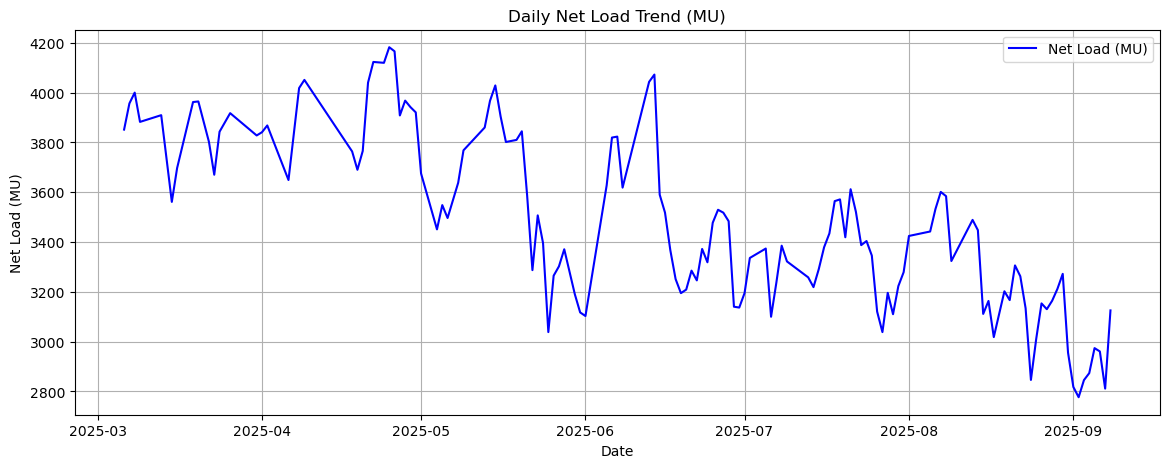

In [4]:
plt.figure(figsize=(14,5))
plt.plot(df["Date"], df["PNL_Energy_MU"], label="Net Load (MU)", color="blue")
plt.title("Daily Net Load Trend (MU)")
plt.xlabel("Date")
plt.ylabel("Net Load (MU)")
plt.grid(True)
plt.legend()
plt.show()


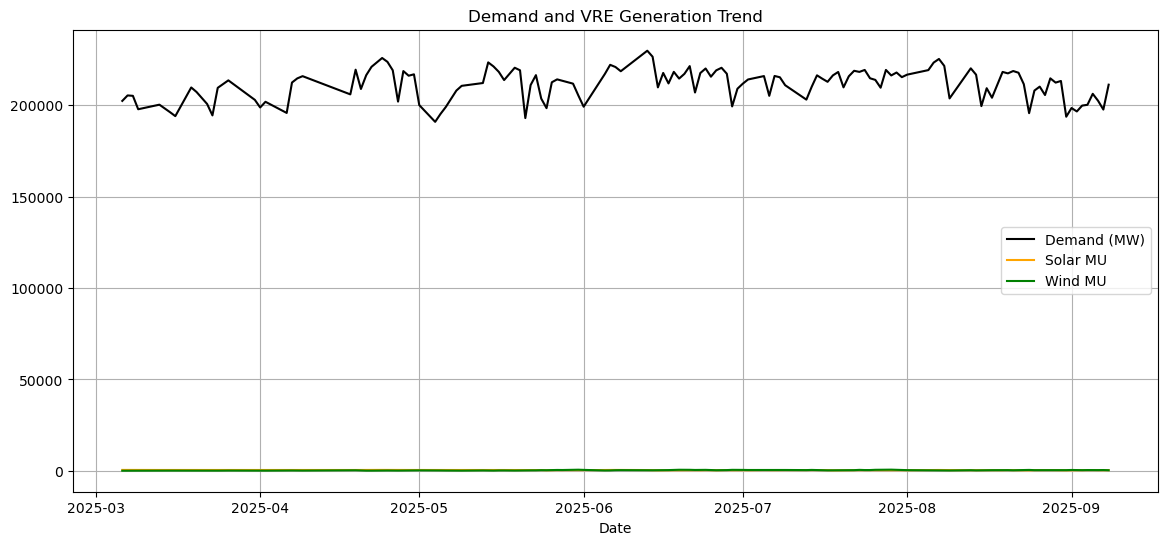

In [5]:
plt.figure(figsize=(14,6))
plt.plot(df["Date"], df["Total_Demand"], label="Demand (MW)", color="black")
plt.plot(df["Date"], df["Total_Solar"], label="Solar MU", color="orange")
plt.plot(df["Date"], df["Total_Wind"], label="Wind MU", color="green")
plt.title("Demand and VRE Generation Trend")
plt.xlabel("Date")
plt.grid(True)
plt.legend()
plt.show()


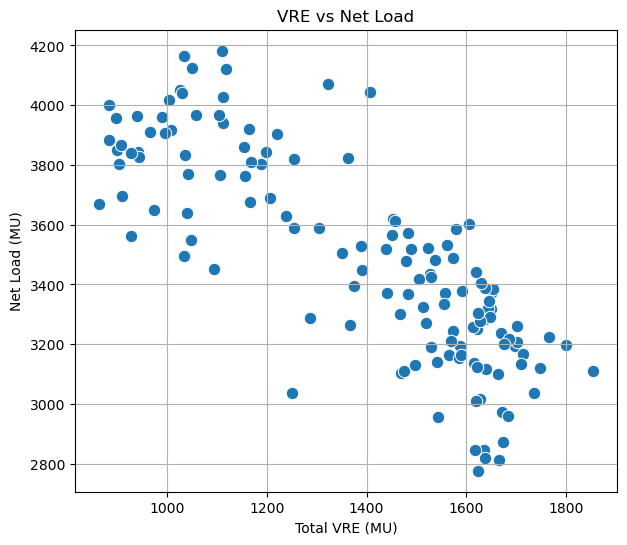

In [6]:
plt.figure(figsize=(7,6))
sns.scatterplot(x=df["Total_VRE_MU"], y=df["PNL_Energy_MU"], s=80)
plt.title("VRE vs Net Load")
plt.xlabel("Total VRE (MU)")
plt.ylabel("Net Load (MU)")
plt.grid(True)
plt.show()


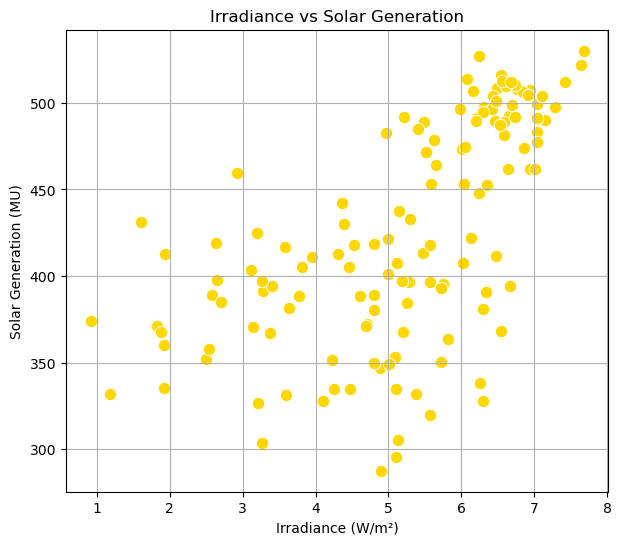

In [7]:
plt.figure(figsize=(7,6))
sns.scatterplot(x=df["ALLSKY_SFC_SW_DWN"], y=df["Total_Solar"], s=80, color="gold")
plt.title("Irradiance vs Solar Generation")
plt.xlabel("Irradiance (W/m²)")
plt.ylabel("Solar Generation (MU)")
plt.grid(True)
plt.show()


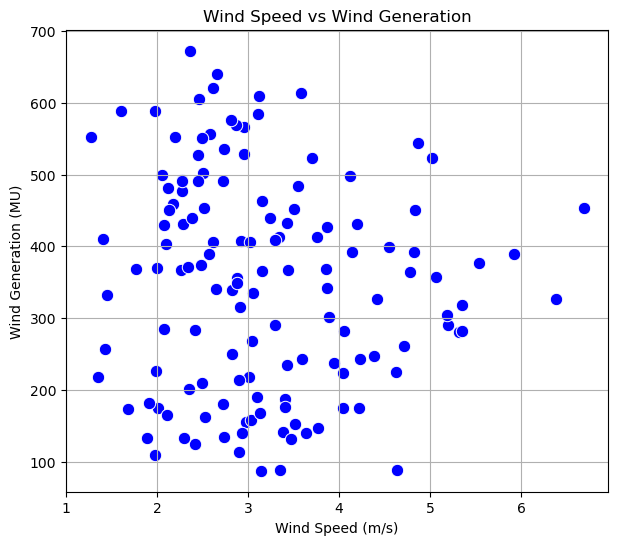

In [8]:
plt.figure(figsize=(7,6))
sns.scatterplot(x=df["WS10M"], y=df["Total_Wind"], s=80, color="blue")
plt.title("Wind Speed vs Wind Generation")
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Wind Generation (MU)")
plt.grid(True)
plt.show()


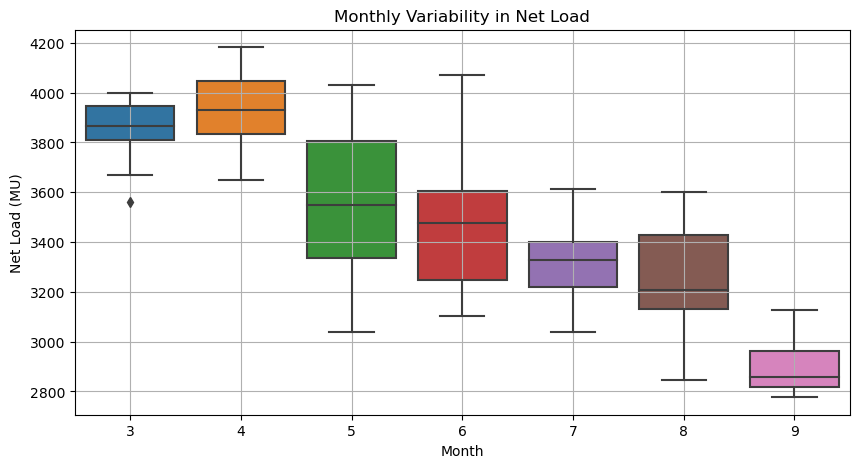

In [9]:
df["Month"] = df["Date"].dt.month

plt.figure(figsize=(10,5))
sns.boxplot(x=df["Month"], y=df["PNL_Energy_MU"])
plt.title("Monthly Variability in Net Load")
plt.xlabel("Month")
plt.ylabel("Net Load (MU)")
plt.grid(True)
plt.show()


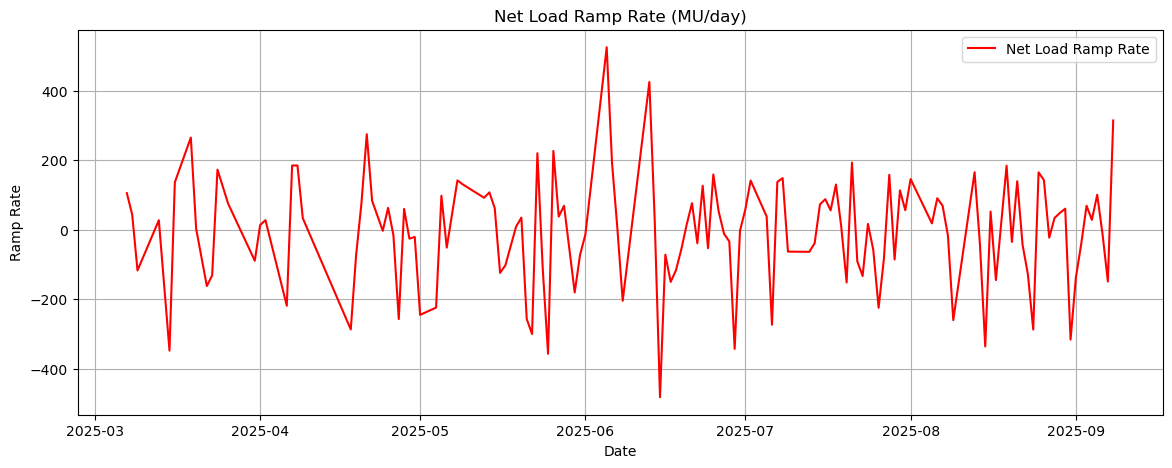

In [10]:
df["NetLoad_Ramp"] = df["PNL_Energy_MU"].diff()

plt.figure(figsize=(14,5))
plt.plot(df["Date"], df["NetLoad_Ramp"], label="Net Load Ramp Rate", color="red")
plt.title("Net Load Ramp Rate (MU/day)")
plt.xlabel("Date")
plt.ylabel("Ramp Rate")
plt.grid(True)
plt.legend()
plt.show()


C:\Users\rjesh\AppData\Local\Temp\ipykernel_17532\3036716403.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), cmap="coolwarm", annot=False)


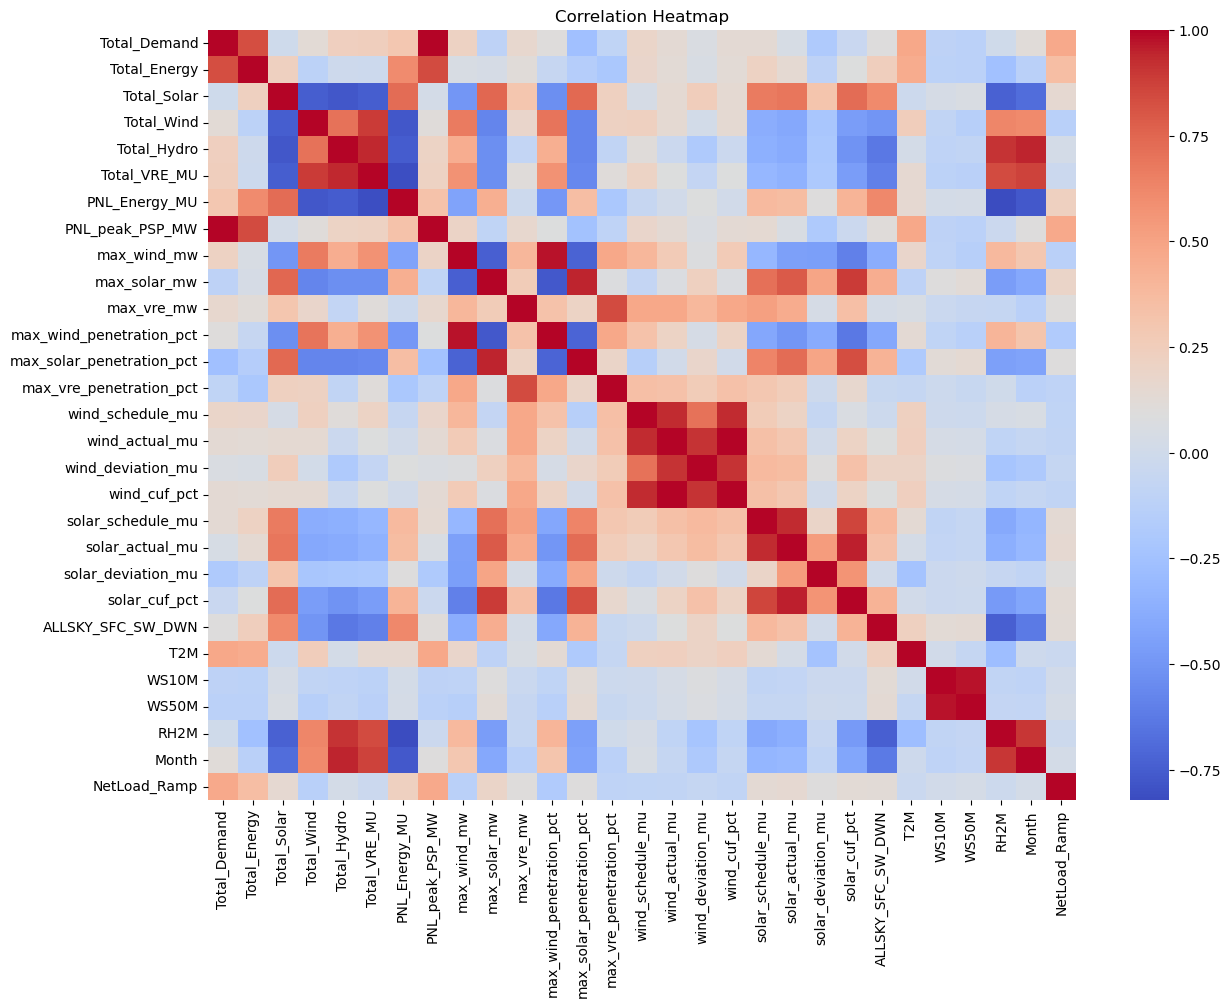

In [11]:
plt.figure(figsize=(14,10))
sns.heatmap(df.corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap")
plt.show()


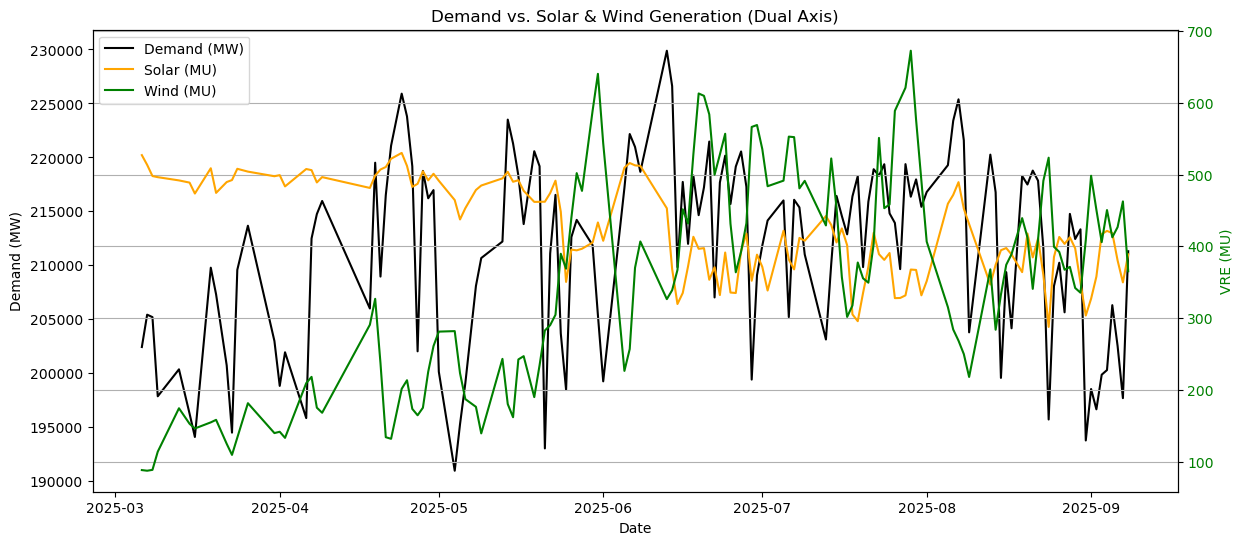

In [12]:
fig, ax1 = plt.subplots(figsize=(14,6))

# Demand on primary y-axis
ax1.plot(df["Date"], df["Total_Demand"], color="black", label="Demand (MW)")
ax1.set_xlabel("Date")
ax1.set_ylabel("Demand (MW)", color="black")
ax1.tick_params(axis="y", labelcolor="black")

# Secondary y-axis for VRE
ax2 = ax1.twinx()
ax2.plot(df["Date"], df["Total_Solar"], color="orange", label="Solar (MU)")
ax2.plot(df["Date"], df["Total_Wind"], color="green", label="Wind (MU)")
ax2.set_ylabel("VRE (MU)", color="green")
ax2.tick_params(axis="y", labelcolor="green")

# Title
plt.title("Demand vs. Solar & Wind Generation (Dual Axis)")

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.grid(True)
plt.show()


In [1]:
import pandas as pd
import numpy as np

file = r"C:\Users\rjesh\vre_reports\final_master_dataset_clean.csv"
df = pd.read_csv(file, parse_dates=["Date"])
df = df.sort_values("Date").reset_index(drop=True)

# Basic temporal features
df["Month"]      = df["Date"].dt.month
df["DayOfWeek"]  = df["Date"].dt.weekday   # 0=Mon, 6=Sun
df["DayOfYear"]  = df["Date"].dt.dayofyear

# Cyclic encoding for annual seasonality
df["DoY_sin"] = np.sin(2 * np.pi * df["DayOfYear"] / 365.0)
df["DoY_cos"] = np.cos(2 * np.pi * df["DayOfYear"] / 365.0)

# Net-load ramp (can be used as lagged feature)
df["NetLoad_Ramp"] = df["PNL_Energy_MU"].diff()



In [2]:
# Lags of target (net load)
for lag in [1, 2, 7]:
    df[f"PNL_lag{lag}"] = df["PNL_Energy_MU"].shift(lag)

# Lags of VRE
for lag in [1, 2, 7]:
    df[f"VRE_lag{lag}"] = df["Total_VRE_MU"].shift(lag)

# Lag of ramp (yesterday's ramp)
df["Ramp_lag1"] = df["NetLoad_Ramp"].shift(1)


In [3]:
# Rolling mean & std of net load (3-day and 7-day)
for win in [3, 7]:
    df[f"PNL_roll_mean_{win}"] = df["PNL_Energy_MU"].rolling(win).mean()
    df[f"PNL_roll_std_{win}"]  = df["PNL_Energy_MU"].rolling(win).std()

# Rolling mean of VRE (3-day)
df["VRE_roll_mean_3"] = df["Total_VRE_MU"].rolling(3).mean()


In [4]:
base_features = [
    # system & VRE
    "Total_Demand",
    "Total_Solar",
    "Total_Wind",
    "Total_Hydro",
    "Total_VRE_MU",
    "PNL_peak_PSP_MW",
    "wind_actual_mu",
    "solar_actual_mu",
    "wind_cuf_pct",
    "solar_cuf_pct",

    # weather
    "ALLSKY_SFC_SW_DWN",
    "T2M",
    "WS10M",
    "WS50M",
    "RH2M",

    # temporal
    "Month",
    "DayOfWeek",
    "DoY_sin",
    "DoY_cos",

    # dynamic behaviour
    "NetLoad_Ramp",
    "Ramp_lag1",
    "PNL_lag1",
    "PNL_lag2",
    "PNL_lag7",
    "PNL_roll_mean_3",
    "PNL_roll_mean_7",
    "PNL_roll_std_3",
    "PNL_roll_std_7",
    "VRE_lag1",
    "VRE_lag2",
    "VRE_lag7",
    "VRE_roll_mean_3",
]

target_col = "PNL_Energy_MU"


In [5]:
df_ml = df.dropna().reset_index(drop=True)

X = df_ml[base_features]
y = df_ml[target_col]

print("Final ML matrix shape:", X.shape)


Final ML matrix shape: (129, 32)


In [6]:
train_frac = 0.8
split_idx = int(len(df_ml) * train_frac)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print("Train size:", X_train.shape, " Test size:", X_test.shape)


Train size: (103, 32)  Test size: (26, 32)


In [7]:
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled  = scaler_X.transform(X_test)


In [8]:
out_file = r"C:\Users\rjesh\vre_reports\ml_feature_matrix_daily.csv"
df_ml.to_csv(out_file, index=False, encoding="utf-8-sig")
print("Saved ML feature matrix to:", out_file)


Saved ML feature matrix to: C:\Users\rjesh\vre_reports\ml_feature_matrix_daily.csv


In [9]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Define model
model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    objective='reg:squarederror',
    random_state=42
)

# Train
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2   = r2_score(y_test, y_pred)

print("XGBoost Performance:")
print("RMSE:", rmse)
print("MAE:", mae)
print("MAPE (%):", mape)
print("R²:", r2)


XGBoost Performance:
RMSE: 225.69164966649558
MAE: 189.03913874098558
MAPE (%): 6.372300014049337
R²: -0.43193747831884677


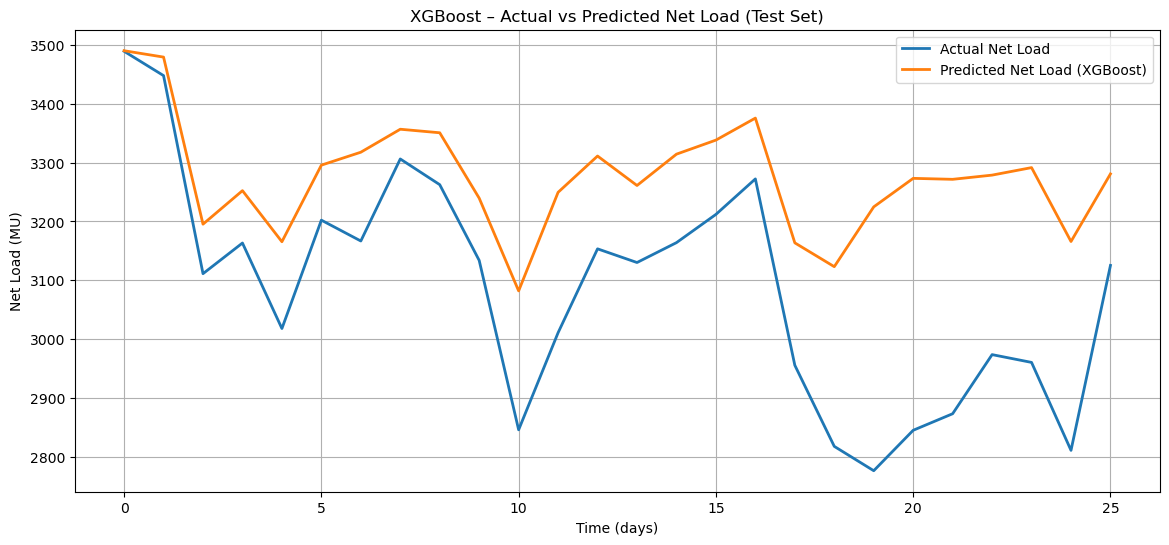

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(y_test.values, label="Actual Net Load", linewidth=2)
plt.plot(y_pred, label="Predicted Net Load (XGBoost)", linewidth=2)
plt.title("XGBoost – Actual vs Predicted Net Load (Test Set)")
plt.xlabel("Time (days)")
plt.ylabel("Net Load (MU)")
plt.legend()
plt.grid(True)
plt.show()


In [11]:
import pandas as pd
import numpy as np

importance = model.feature_importances_
importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": importance
}).sort_values(by="Importance", ascending=False)

print(importance_df.head(15))


            Feature  Importance
21         PNL_lag1    0.672514
24  PNL_roll_mean_3    0.132441
14             RH2M    0.086156
19     NetLoad_Ramp    0.025202
2        Total_Wind    0.023394
5   PNL_peak_PSP_MW    0.010610
16        DayOfWeek    0.009039
29         VRE_lag2    0.006981
17          DoY_sin    0.004245
27   PNL_roll_std_7    0.003715
20        Ramp_lag1    0.003331
1       Total_Solar    0.002495
18          DoY_cos    0.002106
0      Total_Demand    0.002096
12            WS10M    0.001936


In [12]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Summary Plot (most important figure for your paper)
shap.summary_plot(shap_values, X_test, plot_type="bar")


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xf5 in position 1175: invalid start byte

In [13]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xf5 in position 1175: invalid start byte

In [14]:
import shap

# Use training data as background for SHAP
explainer = shap.Explainer(model, X_train)

# Compute SHAP values for test set
shap_values = explainer(X_test)

# Bar summary (global feature importance)
shap.plots.bar(shap_values, max_display=15)

# Detailed beeswarm summary (optional)
shap.plots.beeswarm(shap_values, max_display=15)


TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

            Feature  Importance
21         PNL_lag1    0.672514
24  PNL_roll_mean_3    0.132441
14             RH2M    0.086156
19     NetLoad_Ramp    0.025202
2        Total_Wind    0.023394
5   PNL_peak_PSP_MW    0.010610
16        DayOfWeek    0.009039
29         VRE_lag2    0.006981
17          DoY_sin    0.004245
27   PNL_roll_std_7    0.003715
20        Ramp_lag1    0.003331
1       Total_Solar    0.002495
18          DoY_cos    0.002106
0      Total_Demand    0.002096
12            WS10M    0.001936


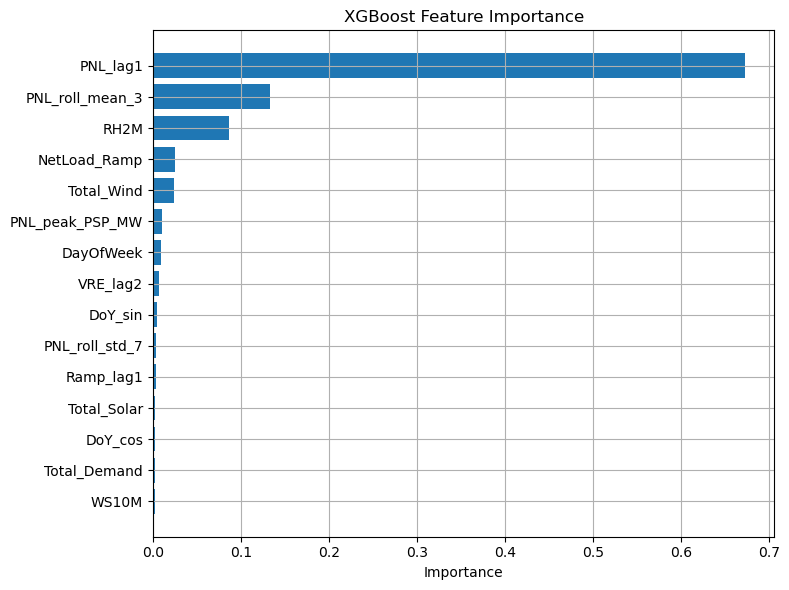

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

importance = model.feature_importances_
imp_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": importance
}).sort_values(by="Importance", ascending=False)

print(imp_df.head(15))

plt.figure(figsize=(8,6))
plt.barh(imp_df["Feature"].head(15)[::-1],
         imp_df["Importance"].head(15)[::-1])
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance")
plt.grid(True)
plt.tight_layout()
plt.show()


              Feature  Importance       Std
0        Total_Demand    0.179738  0.063851
24    PNL_roll_mean_3    0.175430  0.057772
19       NetLoad_Ramp    0.078755  0.050913
2          Total_Wind    0.055924  0.030842
5     PNL_peak_PSP_MW    0.036645  0.014366
21           PNL_lag1    0.030639  0.014959
16          DayOfWeek    0.021022  0.020506
1         Total_Solar    0.013591  0.008862
12              WS10M    0.007881  0.008857
20          Ramp_lag1    0.006471  0.026996
10  ALLSKY_SFC_SW_DWN    0.003765  0.007352
31    VRE_roll_mean_3    0.002503  0.000888
22           PNL_lag2    0.001154  0.000471
28           VRE_lag1    0.000856  0.000961
4        Total_VRE_MU    0.000442  0.002845


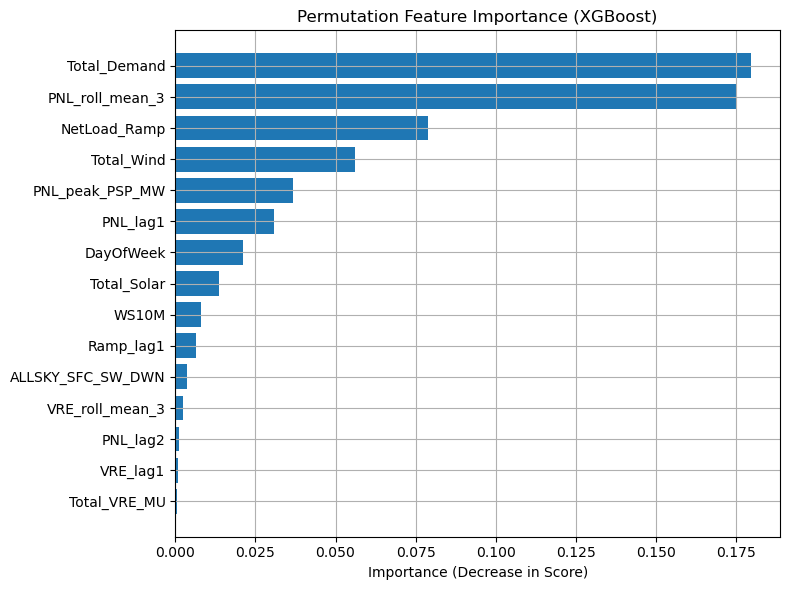

In [16]:
from sklearn.inspection import permutation_importance

perm = permutation_importance(
    model, X_test, y_test,
    n_repeats=20,
    random_state=42
)

perm_imp = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": perm.importances_mean,
    "Std": perm.importances_std
}).sort_values(by="Importance", ascending=False)

print(perm_imp.head(15))

plt.figure(figsize=(8,6))
plt.barh(perm_imp["Feature"].head(15)[::-1],
         perm_imp["Importance"].head(15)[::-1])
plt.title("Permutation Feature Importance (XGBoost)")
plt.xlabel("Importance (Decrease in Score)")
plt.grid(True)
plt.tight_layout()
plt.show()


              Feature  Importance       Std
0        Total_Demand    0.179738  0.063851
24    PNL_roll_mean_3    0.175430  0.057772
19       NetLoad_Ramp    0.078755  0.050913
2          Total_Wind    0.055924  0.030842
5     PNL_peak_PSP_MW    0.036645  0.014366
21           PNL_lag1    0.030639  0.014959
16          DayOfWeek    0.021022  0.020506
1         Total_Solar    0.013591  0.008862
12              WS10M    0.007881  0.008857
20          Ramp_lag1    0.006471  0.026996
10  ALLSKY_SFC_SW_DWN    0.003765  0.007352
31    VRE_roll_mean_3    0.002503  0.000888
22           PNL_lag2    0.001154  0.000471
28           VRE_lag1    0.000856  0.000961
4        Total_VRE_MU    0.000442  0.002845


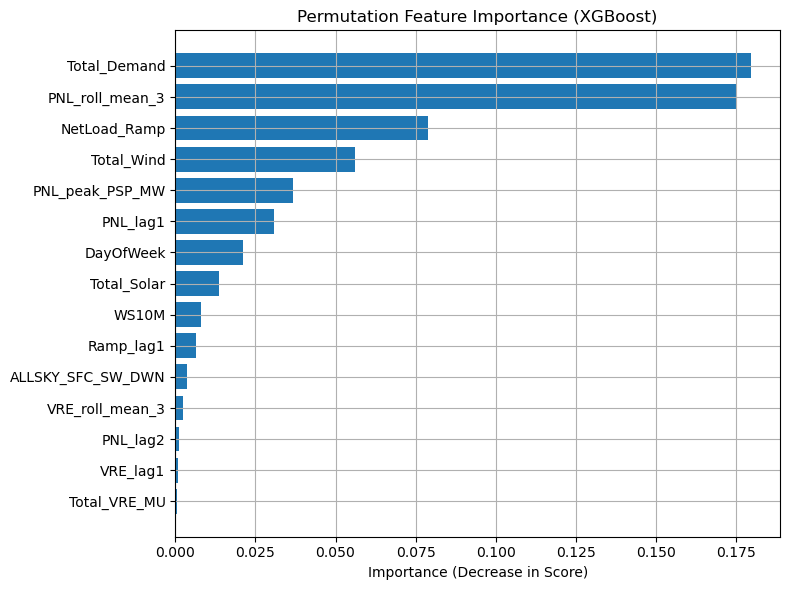

In [17]:
from sklearn.inspection import permutation_importance

perm = permutation_importance(
    model, X_test, y_test,
    n_repeats=20,
    random_state=42
)

perm_imp = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": perm.importances_mean,
    "Std": perm.importances_std
}).sort_values(by="Importance", ascending=False)

print(perm_imp.head(15))

plt.figure(figsize=(8,6))
plt.barh(perm_imp["Feature"].head(15)[::-1],
         perm_imp["Importance"].head(15)[::-1])
plt.title("Permutation Feature Importance (XGBoost)")
plt.xlabel("Importance (Decrease in Score)")
plt.grid(True)
plt.tight_layout()
plt.show()


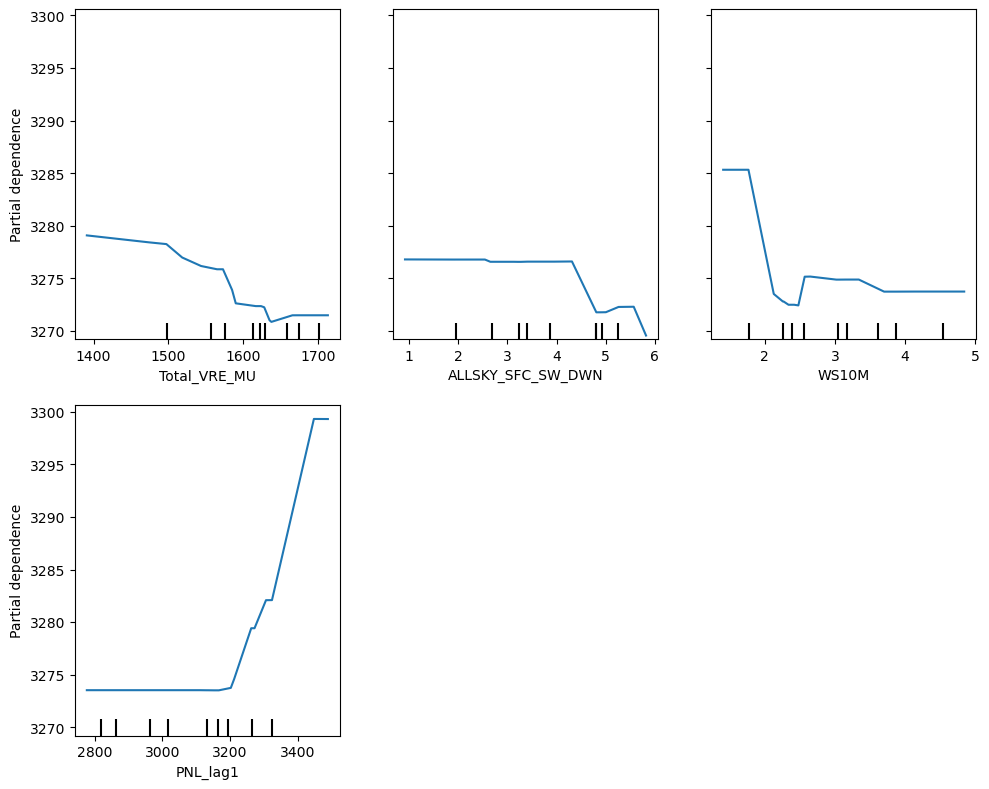

In [18]:
from sklearn.inspection import PartialDependenceDisplay

features_to_plot = ["Total_VRE_MU", "ALLSKY_SFC_SW_DWN", "WS10M", "PNL_lag1"]

fig, ax = plt.subplots(figsize=(10,8))
PartialDependenceDisplay.from_estimator(
    model, X_test, features_to_plot, ax=ax
)
plt.tight_layout()
plt.show()


In [19]:
!pip install shap==0.45.0 --no-cache-dir


     -------------------------------------- 453.1/453.1 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: shap
    Found existing installation: shap 0.41.0
    Uninstalling shap-0.41.0:
      Successfully uninstalled shap-0.41.0


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\rjesh\\anaconda3\\Lib\\site-packages\\~hap\\_cext.cp310-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [20]:
import pickle

model_path = r"C:\Users\rjesh\vre_reports\xgboost_model.pkl"

with open(model_path, "wb") as f:
    pickle.dump(model, f)

print("Model saved to:", model_path)


Model saved to: C:\Users\rjesh\vre_reports\xgboost_model.pkl


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
file_fm = r"C:\Users\rjesh\vre_reports\ml_feature_matrix_daily.csv"
df = pd.read_csv(file_fm)

target_col = "PNL_Energy_MU"
print(df.shape)
df.head()


(129, 52)


Date  Total_Demand  Total_Energy  Total_Solar  Total_Wind  \
0  2025-03-19      209779.0       4953.08     508.7300      154.58   
1  2025-03-20      207311.0       4905.45     474.4000      158.10   
2  2025-03-22      200730.0       4707.18     489.5140      124.70   
3  2025-03-23      194497.0       4535.13     492.3010      109.25   
4  2025-03-24      209581.0       4784.39     507.9796      133.17   

   Total_Hydro  Total_VRE_MU  PNL_Energy_MU  PNL_peak_PSP_MW  max_wind_mw  \
0       327.70      991.0100      3962.0700      208787.9900         9903   
1       308.49      940.9900      3964.4600      206370.0100        11694   
2       290.78      904.9940      3802.1860      199825.0060         8121   
3       263.33      864.8810      3670.2490      193632.1190         8172   
4       300.35      941.4996      3842.8904      208639.5004         8862   

   ... PNL_lag7  VRE_lag1 VRE_lag2  VRE_lag7 Ramp_lag1  PNL_roll_mean_3  \
0  ...  3851.40   909.460  928.120    900.35   136.070      3740.193333   
1  ...  3956.39   991.010  909.460    897.39   264.780      3874.606667   
2  ...  3999.90   940.990  991.010    883.59     2.390      3909.572000   
3  ...  3882.38   904.994  940.990    883.82  -162.274      3812.298333   
4  ...  3909.40   864.881  904.994    966.10  -131.937      3771.775133   

  PNL_roll_std_3  PNL_roll_mean_7 PNL_roll_std_7  VRE_roll_mean_3  
0     203.839895      3852.664286     162.064748       942.863333  
1     153.565387      3853.817143     162.951859       947.153333  
2      93.006681      3825.572286     150.033896       945.664667  
3     147.365948      3795.267857     157.866356       903.621667  
4      90.248983      3785.766486     151.734717       903.791533  

[5 rows x 52 columns]

In [3]:
base_features = [
    "Total_Demand",
    "Total_Solar",
    "Total_Wind",
    "Total_Hydro",
    "Total_VRE_MU",
    "PNL_peak_PSP_MW",
    "wind_actual_mu",
    "solar_actual_mu",
    "wind_cuf_pct",
    "solar_cuf_pct",
    "ALLSKY_SFC_SW_DWN",
    "T2M",
    "WS10M",
    "WS50M",
    "RH2M",
    "Month",
    "DayOfWeek",
    "DoY_sin",
    "DoY_cos",
    "NetLoad_Ramp",
    "Ramp_lag1",
    "PNL_lag1",
    "PNL_lag2",
    "PNL_lag7",
    "PNL_roll_mean_3",
    "PNL_roll_mean_7",
    "PNL_roll_std_3",
    "PNL_roll_std_7",
    "VRE_lag1",
    "VRE_lag2",
    "VRE_lag7",
    "VRE_roll_mean_3",
]

X = df[base_features].copy()
y = df[target_col].values.reshape(-1, 1)

print("X shape:", X.shape, "y shape:", y.shape)


X shape: (129, 32) y shape: (129, 1)


In [4]:
n = len(df)
train_end = int(0.7 * n)
val_end   = int(0.85 * n)

X_train = X.iloc[:train_end].copy()
X_val   = X.iloc[train_end:val_end].copy()
X_test  = X.iloc[val_end:].copy()

y_train = y[:train_end]
y_val   = y[train_end:val_end]
y_test  = y[val_end:]

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Train: (90, 32) Val: (19, 32) Test: (20, 32)


In [5]:
feat_scaler = StandardScaler()
tgt_scaler  = StandardScaler()

X_train_scaled = feat_scaler.fit_transform(X_train)
X_val_scaled   = feat_scaler.transform(X_val)
X_test_scaled  = feat_scaler.transform(X_test)

y_train_scaled = tgt_scaler.fit_transform(y_train)
y_val_scaled   = tgt_scaler.transform(y_val)
y_test_scaled  = tgt_scaler.transform(y_test)


In [6]:
def create_sequences(X_arr, y_arr, window):
    X_seq, y_seq = [], []
    for i in range(window, len(X_arr)):
        X_seq.append(X_arr[i-window:i, :])
        y_seq.append(y_arr[i, 0])
    return np.array(X_seq), np.array(y_seq)

window = 7  # 7 days history

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, window)
X_val_seq,   y_val_seq   = create_sequences(X_val_scaled,   y_val_scaled,   window)
X_test_seq,  y_test_seq  = create_sequences(X_test_scaled,  y_test_scaled,  window)

print("Train seq:", X_train_seq.shape, "Val seq:", X_val_seq.shape, "Test seq:", X_test_seq.shape)


Train seq: (83, 7, 32) Val seq: (12, 7, 32) Test seq: (13, 7, 32)


In [7]:
tf.random.set_seed(42)

n_timesteps = X_train_seq.shape[1]
n_features  = X_train_seq.shape[2]

lstm_model = Sequential([
    LSTM(64, input_shape=(n_timesteps, n_features), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

lstm_model.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mae']
)

lstm_model.summary()

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

history_lstm = lstm_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=300,
    batch_size=8,
    callbacks=[early_stop],
    verbose=1
)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 26945 (105.25 KB)
Trainable params: 26945 (105.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/300


11/11 [==============================] - 7s 104ms/step - loss: 0.7624 - mae: 0.6858 - val_loss: 0.3846 - val_mae: 0.5697
Epoch 2/300
11

In [8]:
# Predict (scaled)
y_pred_test_scaled = lstm_model.predict(X_test_seq)

# Inverse scale
y_pred_test = tgt_scaler.inverse_transform(y_pred_test_scaled.reshape(-1,1)).ravel()
y_true_test = tgt_scaler.inverse_transform(y_test_seq.reshape(-1,1)).ravel()

rmse = np.sqrt(mean_squared_error(y_true_test, y_pred_test))
mae  = mean_absolute_error(y_true_test, y_pred_test)

mape = np.mean(np.abs((y_true_test - y_pred_test) / y_true_test)) * 100
r2   = r2_score(y_true_test, y_pred_test)

print("LSTM Performance on Test:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"MAPE: {mape:.2f} %")
print(f"R²  : {r2:.4f}")

# Plot actual vs predicted
plt.figure(figsize=(12,5))
plt.plot(y_true_test, label='Actual Net Load', marker='o')
plt.plot(y_pred_test, label='Predicted Net Load (LSTM)', marker='s')
plt.xlabel('Time (days in test set)')
plt.ylabel('Net Load (MU)')
plt.title('LSTM – Actual vs Predicted Net Load (Test Set)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 [==============================] - 1s 802ms/step
LSTM Performance on Test:
RMSE: 407.25
MAE : 376.03
MAPE: 12.87 %
R²  : -5.3298


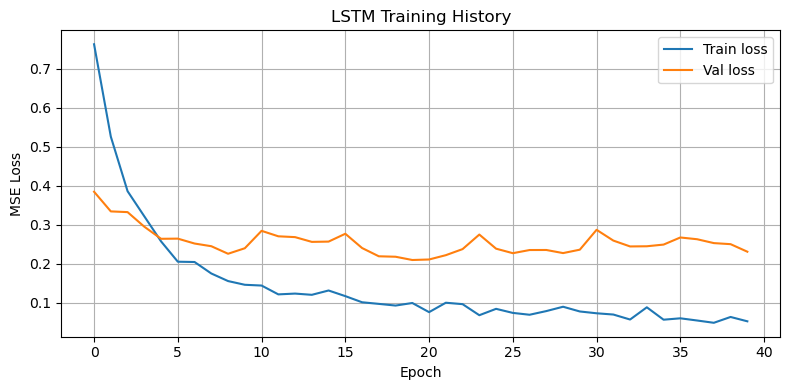

In [9]:
plt.figure(figsize=(8,4))
plt.plot(history_lstm.history['loss'], label='Train loss')
plt.plot(history_lstm.history['val_loss'], label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('LSTM Training History')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
bilstm_model = Sequential([
    Bidirectional(LSTM(64, return_sequences=False), input_shape=(n_timesteps, n_features)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

bilstm_model.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mae']
)

bilstm_model.summary()

early_stop_bi = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

history_bilstm = bilstm_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=300,
    batch_size=8,
    callbacks=[early_stop_bi],
    verbose=1
)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 128)               49664     
 al)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 53825 (210.25 KB)
Trainable params: 53825 (210.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/300
11/11 [==============================] - 9s 153ms/step - loss: 0.6923 

1/1 [==============================] - 1s 978ms/step
BiLSTM Performance on Test:
RMSE: 466.55
MAE : 434.86
MAPE: 14.86 %
R²  : -7.3072


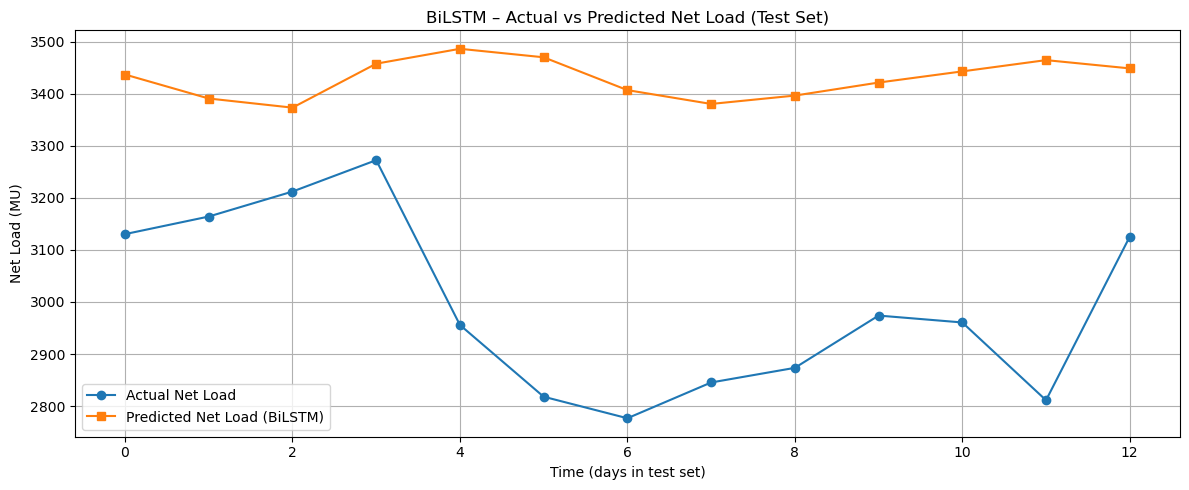

In [11]:
y_pred_bi_scaled = bilstm_model.predict(X_test_seq)

y_pred_bi = tgt_scaler.inverse_transform(y_pred_bi_scaled.reshape(-1,1)).ravel()

rmse_bi = np.sqrt(mean_squared_error(y_true_test, y_pred_bi))
mae_bi  = mean_absolute_error(y_true_test, y_pred_bi)
mape_bi = np.mean(np.abs((y_true_test - y_pred_bi) / y_true_test)) * 100
r2_bi   = r2_score(y_true_test, y_pred_bi)

print("BiLSTM Performance on Test:")
print(f"RMSE: {rmse_bi:.2f}")
print(f"MAE : {mae_bi:.2f}")
print(f"MAPE: {mape_bi:.2f} %")
print(f"R²  : {r2_bi:.4f}")

plt.figure(figsize=(12,5))
plt.plot(y_true_test, label='Actual Net Load', marker='o')
plt.plot(y_pred_bi, label='Predicted Net Load (BiLSTM)', marker='s')
plt.xlabel('Time (days in test set)')
plt.ylabel('Net Load (MU)')
plt.title('BiLSTM – Actual vs Predicted Net Load (Test Set)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
results = pd.DataFrame({
    "Model": ["XGBoost", "LSTM", "BiLSTM"],
    "RMSE": [225.69, rmse, rmse_bi],
    "MAE":  [189.04, mae,  mae_bi],
    "MAPE": [6.37,    mape, mape_bi],
    "R2":   [-0.432,  r2,   r2_bi]
})
print(results)


     Model        RMSE         MAE       MAPE        R2
0  XGBoost  225.690000  189.040000   6.370000 -0.432000
1     LSTM  407.252165  376.031851  12.873052 -5.329817
2   BiLSTM  466.547590  434.859994  14.862639 -7.307230


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping


In [14]:
file_fm = r"C:\Users\rjesh\vre_reports\ml_feature_matrix_daily.csv"
df = pd.read_csv(file_fm)
df['Date'] = pd.to_datetime(df['Date'])

target_col = "PNL_Energy_MU"

base_features = [
    "Total_Demand",
    "Total_Solar",
    "Total_Wind",
    "Total_Hydro",
    "Total_VRE_MU",
    "PNL_peak_PSP_MW",
    "wind_actual_mu",
    "solar_actual_mu",
    "wind_cuf_pct",
    "solar_cuf_pct",
    "ALLSKY_SFC_SW_DWN",
    "T2M",
    "WS10M",
    "WS50M",
    "RH2M",
    "Month",
    "DayOfWeek",
    "DoY_sin",
    "DoY_cos",
    "NetLoad_Ramp",
    "Ramp_lag1",
    "PNL_lag1",
    "PNL_lag2",
    "PNL_lag7",
    "PNL_roll_mean_3",
    "PNL_roll_mean_7",
    "PNL_roll_std_3",
    "PNL_roll_std_7",
    "VRE_lag1",
    "VRE_lag2",
    "VRE_lag7",
    "VRE_roll_mean_3",
]

X = df[base_features].copy()
y = df[target_col].values
n = len(df)
print("Rows:", n)


Rows: 129


In [15]:
train_end = int(0.7 * n)
val_end   = int(0.85 * n)

X_train = X.iloc[:train_end]
X_val   = X.iloc[train_end:val_end]
X_test  = X.iloc[val_end:]

y_train = y[:train_end]
y_val   = y[train_end:val_end]
y_test  = y[val_end:]

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Train: (90, 32) Val: (19, 32) Test: (20, 32)


In [16]:
xgb_model = XGBRegressor(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

xgb_model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              early_stopping_rounds=20,
              verbose=False)

# Predictions
y_pred_train_xgb = xgb_model.predict(X_train)
y_pred_val_xgb   = xgb_model.predict(X_val)
y_pred_test_xgb  = xgb_model.predict(X_test)

# Quick baseline metrics on full test set
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_test_xgb))
mae_xgb  = mean_absolute_error(y_test, y_pred_test_xgb)
mape_xgb = np.mean(np.abs((y_test - y_pred_test_xgb) / y_test)) * 100
r2_xgb   = r2_score(y_test, y_pred_test_xgb)

print("XGBoost Test Performance (full test set):")
print(f"RMSE: {rmse_xgb:.2f}, MAE: {mae_xgb:.2f}, MAPE: {mape_xgb:.2f} %, R²: {r2_xgb:.4f}")


TypeError: XGBModel.fit() got an unexpected keyword argument 'early_stopping_rounds'

In [17]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

# Remove early_stopping_rounds from fit()
xgb_model.fit(
    X_train, 
    y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)

# Predictions
y_pred_train_xgb = xgb_model.predict(X_train)
y_pred_val_xgb   = xgb_model.predict(X_val)
y_pred_test_xgb  = xgb_model.predict(X_test)


[0]	validation_0-rmse:340.83684
[1]	validation_0-rmse:327.54277
[2]	validation_0-rmse:318.63631
[3]	validation_0-rmse:307.65810
[4]	validation_0-rmse:297.30422
[5]	validation_0-rmse:288.46875
[6]	validation_0-rmse:279.12159
[7]	validation_0-rmse:270.50226
[8]	validation_0-rmse:261.40377
[9]	validation_0-rmse:256.83634
[10]	validation_0-rmse:250.55914
[11]	validation_0-rmse:243.15892
[12]	validation_0-rmse:237.67031
[13]	validation_0-rmse:231.11262
[14]	validation_0-rmse:223.84999
[15]	validation_0-rmse:218.03217
[16]	validation_0-rmse:213.25337
[17]	validation_0-rmse:208.25470
[18]	validation_0-rmse:204.14310
[19]	validation_0-rmse:199.70254
[20]	validation_0-rmse:194.20692
[21]	validation_0-rmse:190.61318
[22]	validation_0-rmse:187.77619
[23]	validation_0-rmse:183.54664
[24]	validation_0-rmse:179.41716
[25]	validation_0-rmse:177.08381
[26]	validation_0-rmse:173.61854
[27]	validation_0-rmse:171.62911
[28]	validation_0-rmse:168.11873
[29]	validation_0-rmse:166.04593
[30]	validation_0-rm

[246]	validation_0-rmse:99.94571
[247]	validation_0-rmse:99.93851
[248]	validation_0-rmse:99.93675
[249]	validation_0-rmse:99.94877
[250]	validation_0-rmse:99.93376
[251]	validation_0-rmse:99.93419
[252]	validation_0-rmse:99.93508
[253]	validation_0-rmse:99.92706
[254]	validation_0-rmse:99.93340
[255]	validation_0-rmse:99.91829
[256]	validation_0-rmse:99.91960
[257]	validation_0-rmse:99.92629
[258]	validation_0-rmse:99.93493
[259]	validation_0-rmse:99.92652
[260]	validation_0-rmse:99.93663
[261]	validation_0-rmse:99.94294
[262]	validation_0-rmse:99.93955
[263]	validation_0-rmse:99.94700
[264]	validation_0-rmse:99.93833
[265]	validation_0-rmse:99.92083
[266]	validation_0-rmse:99.91024
[267]	validation_0-rmse:99.91507
[268]	validation_0-rmse:99.91765
[269]	validation_0-rmse:99.91694
[270]	validation_0-rmse:99.90968
[271]	validation_0-rmse:99.90919
[272]	validation_0-rmse:99.90471
[273]	validation_0-rmse:99.90208
[274]	validation_0-rmse:99.90097
[275]	validation_0-rmse:99.90484
[276]	vali

In [18]:
import xgboost as xgb

# 1) Build DMatrices
dtrain = xgb.DMatrix(X_train, label=y_train)
dval   = xgb.DMatrix(X_val,   label=y_val)
dtest  = xgb.DMatrix(X_test,  label=y_test)
dall   = xgb.DMatrix(X,       label=y)

# 2) Set parameters
params = {
    "max_depth": 4,
    "eta": 0.05,                  # learning_rate
    "subsample": 0.9,
    "colsample_bytree": 0.8,
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "seed": 42
}

watchlist = [(dtrain, "train"), (dval, "val")]

# 3) Train with early stopping
xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    evals=watchlist,
    early_stopping_rounds=20,
    verbose_eval=True   # you can set to 50 or False if too chatty
)

# 4) Predictions
y_pred_train_xgb = xgb_model.predict(dtrain)
y_pred_val_xgb   = xgb_model.predict(dval)
y_pred_test_xgb  = xgb_model.predict(dtest)

# 5) Test metrics (full test set)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_test_xgb))
mae_xgb  = mean_absolute_error(y_test, y_pred_test_xgb)
mape_xgb = np.mean(np.abs((y_test - y_pred_test_xgb) / y_test)) * 100
r2_xgb   = r2_score(y_test, y_pred_test_xgb)

print("XGBoost Test Performance (full test set):")
print(f"RMSE: {rmse_xgb:.2f}, MAE: {mae_xgb:.2f}, MAPE: {mape_xgb:.2f} %, R²: {r2_xgb:.4f}")


[0]	train-rmse:290.37267	val-rmse:340.83684
[1]	train-rmse:277.63947	val-rmse:327.54277
[2]	train-rmse:265.94928	val-rmse:318.63631
[3]	train-rmse:254.74478	val-rmse:307.65810
[4]	train-rmse:243.92959	val-rmse:297.30422
[5]	train-rmse:233.39724	val-rmse:288.46875
[6]	train-rmse:223.97710	val-rmse:279.12159
[7]	train-rmse:214.49840	val-rmse:270.50226
[8]	train-rmse:205.81113	val-rmse:261.40377
[9]	train-rmse:197.01786	val-rmse:256.83634
[10]	train-rmse:188.98555	val-rmse:250.55914
[11]	train-rmse:181.10270	val-rmse:243.15892
[12]	train-rmse:173.81258	val-rmse:237.67031
[13]	train-rmse:166.63448	val-rmse:231.11262
[14]	train-rmse:159.51008	val-rmse:223.84999
[15]	train-rmse:153.12410	val-rmse:218.03217
[16]	train-rmse:147.32902	val-rmse:213.25337
[17]	train-rmse:141.91014	val-rmse:208.25470
[18]	train-rmse:136.33424	val-rmse:204.14310
[19]	train-rmse:130.90984	val-rmse:199.70254
[20]	train-rmse:125.62705	val-rmse:194.20692
[21]	train-rmse:120.90176	val-rmse:190.61318
[22]	train-rmse:115.

[186]	train-rmse:1.90571	val-rmse:100.21893
[187]	train-rmse:1.86936	val-rmse:100.20110
[188]	train-rmse:1.84044	val-rmse:100.20081
[189]	train-rmse:1.80963	val-rmse:100.16667
[190]	train-rmse:1.77622	val-rmse:100.12806
[191]	train-rmse:1.75526	val-rmse:100.11920
[192]	train-rmse:1.73274	val-rmse:100.11016
[193]	train-rmse:1.70279	val-rmse:100.10119
[194]	train-rmse:1.67247	val-rmse:100.09104
[195]	train-rmse:1.63944	val-rmse:100.08259
[196]	train-rmse:1.62553	val-rmse:100.04541
[197]	train-rmse:1.59890	val-rmse:100.01942
[198]	train-rmse:1.57507	val-rmse:99.98071
[199]	train-rmse:1.55691	val-rmse:99.98798
[200]	train-rmse:1.54298	val-rmse:99.98465
[201]	train-rmse:1.51135	val-rmse:99.98714
[202]	train-rmse:1.49330	val-rmse:99.99816
[203]	train-rmse:1.47509	val-rmse:99.99648
[204]	train-rmse:1.45423	val-rmse:99.98739
[205]	train-rmse:1.43099	val-rmse:99.96748
[206]	train-rmse:1.41209	val-rmse:99.96345
[207]	train-rmse:1.38398	val-rmse:99.97711
[208]	train-rmse:1.35575	val-rmse:99.94617

In [19]:
# XGBoost predictions on ALL rows
y_pred_all_xgb = xgb_model.predict(dall)   # length = n

residual_all = y - y_pred_all_xgb          # actual - xgb

df_hybrid = df.copy()
df_hybrid["XGB_pred"] = y_pred_all_xgb
df_hybrid["Residual"] = residual_all

hybrid_features = base_features + ["XGB_pred"]

X_hybrid = df_hybrid[hybrid_features].copy()
resid    = df_hybrid["Residual"].values.reshape(-1, 1)


In [20]:
Xh_train = X_hybrid.iloc[:train_end]
Xh_val   = X_hybrid.iloc[train_end:val_end]
Xh_test  = X_hybrid.iloc[val_end:]

resid_train = resid[:train_end]
resid_val   = resid[train_end:val_end]
resid_test  = resid[val_end:]

from sklearn.preprocessing import StandardScaler

feat_scaler_h = StandardScaler()
resid_scaler  = StandardScaler()

Xh_train_scaled = feat_scaler_h.fit_transform(Xh_train)
Xh_val_scaled   = feat_scaler_h.transform(Xh_val)
Xh_test_scaled  = feat_scaler_h.transform(Xh_test)

resid_train_scaled = resid_scaler.fit_transform(resid_train)
resid_val_scaled   = resid_scaler.transform(resid_val)
resid_test_scaled  = resid_scaler.transform(resid_test)


In [21]:
Xh_train = X_hybrid.iloc[:train_end]
Xh_val   = X_hybrid.iloc[train_end:val_end]
Xh_test  = X_hybrid.iloc[val_end:]

resid_train = resid[:train_end]
resid_val   = resid[train_end:val_end]
resid_test  = resid[val_end:]

from sklearn.preprocessing import StandardScaler

feat_scaler_h = StandardScaler()
resid_scaler  = StandardScaler()

Xh_train_scaled = feat_scaler_h.fit_transform(Xh_train)
Xh_val_scaled   = feat_scaler_h.transform(Xh_val)
Xh_test_scaled  = feat_scaler_h.transform(Xh_test)

resid_train_scaled = resid_scaler.fit_transform(resid_train)
resid_val_scaled   = resid_scaler.transform(resid_val)
resid_test_scaled  = resid_scaler.transform(resid_test)


In [22]:
def create_sequences(X_arr, y_arr, window):
    X_seq, y_seq = [], []
    for i in range(window, len(X_arr)):
        X_seq.append(X_arr[i-window:i, :])
        y_seq.append(y_arr[i, 0])
    return np.array(X_seq), np.array(y_seq)

window = 7

Xh_train_seq, resid_train_seq = create_sequences(Xh_train_scaled, resid_train_scaled, window)
Xh_val_seq,   resid_val_seq   = create_sequences(Xh_val_scaled,   resid_val_scaled,   window)
Xh_test_seq,  resid_test_seq  = create_sequences(Xh_test_scaled,  resid_test_scaled,  window)

print("Residual LSTM shapes:")
print("Train:", Xh_train_seq.shape, "Val:", Xh_val_seq.shape, "Test:", Xh_test_seq.shape)

tf.random.set_seed(42)

n_timesteps = Xh_train_seq.shape[1]
n_features  = Xh_train_seq.shape[2]

res_lstm = Sequential([
    LSTM(32, input_shape=(n_timesteps, n_features), return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

res_lstm.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mae']
)

early_stop_res = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

history_res = res_lstm.fit(
    Xh_train_seq, resid_train_seq,
    validation_data=(Xh_val_seq, resid_val_seq),
    epochs=300,
    batch_size=8,
    callbacks=[early_stop_res],
    verbose=1
)


Residual LSTM shapes:
Train: (83, 7, 33) Val: (12, 7, 33) Test: (13, 7, 33)
Epoch 1/300
11/11 [==============================] - 4s 82ms/step - loss: 1.1098 - mae: 0.8048 - val_loss: 10900.3311 - val_mae: 79.0697
Epoch 2/300
11/11 [==============================] - 0s 10ms/step - loss: 1.0513 - mae: 0.7697 - val_loss: 10904.9736 - val_mae: 79.0901
Epoch 3/300
11/11 [==============================] - 0s 11ms/step - loss: 0.9876 - mae: 0.7485 - val_loss: 10897.5908 - val_mae: 79.0682
Epoch 4/300
11/11 [==============================] - 0s 10ms/step - loss: 0.9386 - mae: 0.7190 - val_loss: 10898.3037 - val_mae: 79.0717
Epoch 5/300
11/11 [==============================] - 0s 11ms/step - loss: 0.9272 - mae: 0.7181 - val_loss: 10898.3955 - val_mae: 79.0726
Epoch 6/300
11/11 [==============================] - 0s 11ms/step - loss: 0.9106 - mae: 0.7151 - val_loss: 10901.4521 - val_mae: 79.0830
Epoch 7/300
11/11 [==============================] - 0s 11ms/step - loss: 0.8935 - mae: 0.6972 - val_l

In [23]:
# Residual predictions (scaled)
resid_pred_test_scaled = res_lstm.predict(Xh_test_seq)
resid_pred_test = resid_scaler.inverse_transform(resid_pred_test_scaled.reshape(-1,1)).ravel()

# Align with test segment
y_test_aligned = y_test[window:]               # true net load
y_pred_test_xgb_aligned = y_pred_test_xgb[window:]  # baseline XGB on same subset

# Hybrid = XGB + predicted residual
y_pred_test_hybrid = y_pred_test_xgb_aligned + resid_pred_test

def eval_model(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2   = r2_score(y_true, y_pred)
    print(f"{name} Performance (aligned test subset):")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE : {mae:.2f}")
    print(f"  MAPE: {mape:.2f} %")
    print(f"  R²  : {r2:.4f}")
    return rmse, mae, mape, r2

rmse_xgb_sub, mae_xgb_sub, mape_xgb_sub, r2_xgb_sub = eval_model("XGBoost", y_test_aligned, y_pred_test_xgb_aligned)
rmse_hyb, mae_hyb, mape_hyb, r2_hyb = eval_model("Hybrid XGB+LSTM", y_test_aligned, y_pred_test_hybrid)


1/1 [==============================] - 1s 597ms/step
XGBoost Performance (aligned test subset):
  RMSE: 295.27
  MAE : 270.93
  MAPE: 9.28 %
  R²  : -2.3274
Hybrid XGB+LSTM Performance (aligned test subset):
  RMSE: 295.27
  MAE : 270.94
  MAPE: 9.28 %
  R²  : -2.3274


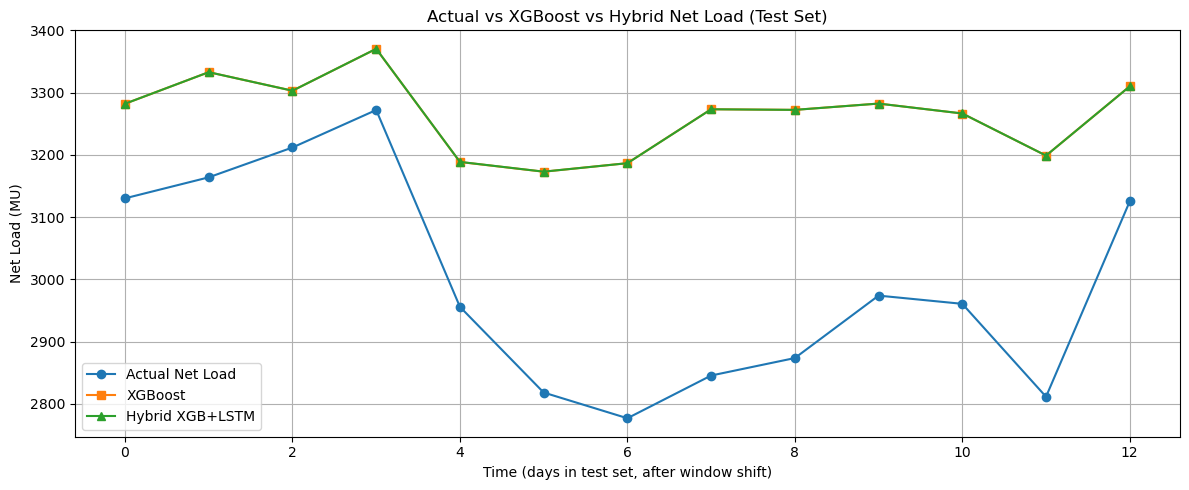

In [24]:
plt.figure(figsize=(12,5))
plt.plot(y_test_aligned, label='Actual Net Load', marker='o')
plt.plot(y_pred_test_xgb_aligned, label='XGBoost', marker='s')
plt.plot(y_pred_test_hybrid, label='Hybrid XGB+LSTM', marker='^')
plt.xlabel('Time (days in test set, after window shift)')
plt.ylabel('Net Load (MU)')
plt.title('Actual vs XGBoost vs Hybrid Net Load (Test Set)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def eval_regression_model(name, y_true, y_pred, results_list):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2   = r2_score(y_true, y_pred)
    print(f"{name} Performance (test set):")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE : {mae:.2f}")
    print(f"  MAPE: {mape:.2f} %")
    print(f"  R²  : {r2:.4f}\n")
    results_list.append([name, rmse, mae, mape, r2])



In [26]:
benchmark_results = []


In [27]:
# y is full target series as 1D array
y = y.reshape(-1) if len(y.shape) > 1 else y

# Indices for each segment
train_idx = np.arange(0, train_end)
val_idx   = np.arange(train_end, val_end)
test_idx  = np.arange(val_end, len(y))

# --- Persistence prediction: y[t] = y[t-1] ---

y_pred_persist = np.empty_like(y, dtype=float)
y_pred_persist[:] = np.nan
y_pred_persist[1:] = y[:-1]  # shift by 1 day

# Extract test subset
y_test_persist = y[test_idx]
y_pred_test_persist = y_pred_persist[test_idx]

# Drop the first point in test if it's nan (in case test starts at index 0 or 1)
mask_valid = ~np.isnan(y_pred_test_persist)
y_test_persist = y_test_persist[mask_valid]
y_pred_test_persist = y_pred_test_persist[mask_valid]

eval_regression_model("Persistence (Naïve)", y_test_persist, y_pred_test_persist, benchmark_results)


Persistence (Naïve) Performance (test set):
  RMSE: 147.35
  MAE : 113.79
  MAPE: 3.78 %
  R²  : 0.2311



In [28]:
from statsmodels.tsa.arima.model import ARIMA

# Build training+validation target series for ARIMA
y_trainval = y[:val_end]         # 0 .. val_end-1
y_test_arima = y[val_end:]       # val_end .. end

# --- Fit ARIMA model ---
# You can tune (p,d,q); (2,1,2) is a reasonable starting point for daily data
order = (2, 1, 2)

arima_model = ARIMA(y_trainval, order=order)
arima_res = arima_model.fit()

# Forecast exactly len(test) steps ahead
n_test = len(y_test_arima)
arima_forecast = arima_res.forecast(steps=n_test)

eval_regression_model("ARIMA(2,1,2)", y_test_arima, arima_forecast, benchmark_results)


ARIMA(2,1,2) Performance (test set):
  RMSE: 223.08
  MAE : 179.17
  MAPE: 6.14 %
  R²  : -0.7624



In [29]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=8,
    min_samples_split=5,
    min_samples_leaf=3,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred_test_rf = rf.predict(X_test)

eval_regression_model("Random Forest", y_test, y_pred_test_rf, benchmark_results)


Random Forest Performance (test set):
  RMSE: 299.39
  MAE : 273.41
  MAPE: 9.24 %
  R²  : -2.1743



In [30]:
# XGBoost
eval_regression_model("XGBoost", y_test, y_pred_test_xgb, benchmark_results)

# LSTM
eval_regression_model("LSTM", y_test, y_pred_test_lstm, benchmark_results)

# BiLSTM
eval_regression_model("BiLSTM", y_test, y_pred_test_bilstm, benchmark_results)

# Hybrid XGB + LSTM (optional – use aligned subset if needed)
# eval_regression_model("Hybrid XGB+LSTM", y_test_aligned, y_pred_test_hybrid, benchmark_results)


XGBoost Performance (test set):
  RMSE: 261.63
  MAE : 233.65
  MAPE: 7.92 %
  R²  : -1.4242



NameError: name 'y_pred_test_lstm' is not defined

In [31]:
results_df = pd.DataFrame(
    benchmark_results,
    columns=["Model", "RMSE", "MAE", "MAPE (%)", "R²"]
).sort_values("RMSE")

results_df.reset_index(drop=True, inplace=True)
results_df


Model        RMSE         MAE  MAPE (%)        R²
0  Persistence (Naïve)  147.347320  113.793250  3.782632  0.231120
1         ARIMA(2,1,2)  223.083952  179.165997  6.137880 -0.762425
2              XGBoost  261.633366  233.650679  7.915898 -1.424154
3        Random Forest  299.392051  273.411698  9.237770 -2.174347

In [32]:
print(results_df.to_string(index=False, float_format=lambda x: f"{x:0.2f}"))



              Model   RMSE    MAE  MAPE (%)    R²
Persistence (Naïve) 147.35 113.79      3.78  0.23
       ARIMA(2,1,2) 223.08 179.17      6.14 -0.76
            XGBoost 261.63 233.65      7.92 -1.42
      Random Forest 299.39 273.41      9.24 -2.17
